In [1]:
import os
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.layers import *
from keras.optimizers import *
from keras.models import Model
from keras.callbacks import *
from keras import backend as K
from keras import optimizers
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import matthews_corrcoef
from joblib import Parallel, delayed

/home/hakubishin3/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### settings

In [2]:
save_dir = "./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.38/"

In [3]:
N_SPLITS = 5
MAX_THREADS = 32
N_TRAIN = 10
max_num = 127
min_num = -128
n_samples = 800000
sample_duration = 0.02
sample_rate = n_samples * (1 / sample_duration)

### process

In [4]:
from scipy.signal import butter, sosfilt
import pywt

def maddest(d, axis=None):
    """
    Mean Absolute Deviation
    """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def high_pass_filter(x, low_cutoff=1000, sample_rate=sample_rate):
    """
    From @randxie https://github.com/randxie/Kaggle-VSB-Baseline/blob/master/src/utils/util_signal.py
    Modified to work with scipy version 1.1.0 which does not have the fs parameter
    """
    # nyquist frequency is half the sample rate https://en.wikipedia.org/wiki/Nyquist_frequency
    nyquist = 0.5 * sample_rate
    norm_low_cutoff = low_cutoff / nyquist
    # scipy version 1.1.0
    sos = butter(10, Wn=[norm_low_cutoff], btype='highpass', output='sos')
    filtered_sig = sosfilt(sos, x)
    return filtered_sig

def denoise_signal(x, wavelet='db4', level=1):
    """
    1. Adapted from waveletSmooth function found here:
    http://connor-johnson.com/2016/01/24/using-pywavelets-to-remove-high-frequency-noise/
    2. Threshold equation and using hard mode in threshold as mentioned
    in section '3.2 denoising based on optimized singular values' from paper by Tomas Vantuch:
    http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    """
    # Decompose to get the wavelet coefficients
    coeff = pywt.wavedec( x, wavelet, mode="per" )
    # Calculate sigma for threshold as defined in http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    # As noted by @harshit92 MAD referred to in the paper is Mean Absolute Deviation not Median Absolute Deviation
    sigma = (1/0.6745) * maddest( coeff[-level] )
    # Calculte the univeral threshold
    uthresh = sigma * np.sqrt( 2*np.log(len(x)))
    coeff[1:] = (pywt.threshold( i, value=uthresh, mode='hard') for i in coeff[1:])
    # Reconstruct the signal using the thresholded coefficients
    return pywt.waverec( coeff, wavelet, mode='per')

In [5]:
df_train = pd.read_csv('../data/input/metadata_train.csv')
df_train = df_train.set_index(['id_measurement', 'phase'])

In [6]:
def get_features(dataset='train', split_parts=10):
    if dataset == 'train':
        cache_file = 'X.npy'
        meta_file = '../data/input/metadata_train.csv'
    elif dataset == 'test':
        cache_file = 'X_test.npy'
        meta_file = '../data/input/metadata_test.csv'

    meta_df = pd.read_csv(meta_file)

    data_measurements = meta_df.pivot(
        index='id_measurement', columns='phase', values='signal_id'
    )
    data_measurements = data_measurements.values
    data_measurements = np.array_split(data_measurements, split_parts, axis=0)
    X = Parallel(n_jobs=min(split_parts, MAX_THREADS), verbose=1)(delayed(prep_data)(p, dataset) for p in data_measurements)
    X = np.concatenate(X, axis=0)

    if dataset == 'train':
        # y = meta_df.loc[meta_df['phase']==0, 'target'].values
        # y = meta_df.groupby("id_measurement")["target"].max().sort_index().values
        y = meta_df.groupby("id_measurement")["target"].sum().values
        y[y < 2] = 0
        y[y >= 2] = 1

        np.save(save_dir + "X.npy", X)
        np.save(save_dir + "y.npy", y)
    elif dataset == 'test':
        y = None
        np.save(save_dir + "X_test.npy", X)

    return X, y

In [7]:
def min_max_transf(ts, min_data, max_data, range_needed=(-1,1)):
    if min_data < 0:
        ts_std = (ts + abs(min_data)) / (max_data + abs(min_data))
    else:
        ts_std = (ts - min_data) / (max_data - min_data)
    if range_needed[0] < 0:    
        return ts_std * (range_needed[1] + abs(range_needed[0])) + range_needed[0]
    else:
        return ts_std * (range_needed[1] - range_needed[0]) + range_needed[0]

In [8]:
def prep_data(signal_ids, dataset="train"):
    signal_ids_all = np.concatenate(signal_ids)
    if dataset == "train":
        praq_data = pq.read_pandas('../data/input/train.parquet', columns=[str(i) for i in signal_ids_all]).to_pandas()
    elif dataset == "test":
        praq_data = pq.read_pandas('../data/input/test.parquet', columns=[str(i) for i in signal_ids_all]).to_pandas()
    else:
        raise ValueError("Unknown dataset")
    X = []
    for sids in signal_ids:
        data = praq_data[[str(s) for s in sids]].values.T
        X_signal = [transform_ts(signal) for signal in data]
        X_signal = np.concatenate(X_signal, axis=1)
        X.append(X_signal)
    X = np.asarray(X)
    return X

In [9]:
from scipy.optimize import leastsq

def fit_sinusoid(signals):
    t = np.linspace(0, 2*np.pi, len(signals))  # data covers one period
    guess_mean = np.mean(signals)
    guess_std = 3*np.std(signals)/(2**0.5)/(2**0.5)
    guess_phase = 0
    guess_freq = 1
    guess_amp = 20

    # Define the function to optimize, in this case, we want to minimize the difference
    # between the actual data and our "guessed" parameters
    optimize_func = lambda x: x[0]*np.sin(x[1]*t+x[2]) + x[3] - signals
    est_amp, est_freq, est_phase, est_mean = leastsq(optimize_func, [guess_amp, guess_freq, guess_phase, guess_mean])[0]

    # recreate the fitted curve using the optimized parameters
    signal_fit = est_amp*np.sin(est_freq*t+est_phase) + est_mean
    return signal_fit

In [10]:
from scipy.signal import butter, sosfilt, find_peaks, peak_prominences
import pywt
    
def transform_ts(ts, n_dim=160, min_max=(-1,1)):
    # fit sinusoid
    ts_deno = denoise_signal(ts)
    fit = fit_sinusoid(ts_deno)
    fit = min_max_transf(fit, min_data=min_num, max_data=max_num)

    # denoised
    ts = high_pass_filter(ts, low_cutoff=10000)
    ts_denoised = denoise_signal(ts, wavelet='db4', level=1)
    ts_denoised = min_max_transf(ts_denoised, min_data=min_num, max_data=max_num)

    # setting
    sample_size = 800000
    bucket_size = int(sample_size / n_dim)
    new_ts = []

    for i in range(0, sample_size, bucket_size):
        # fit sinusoid features
        fit_range = fit[i:i+bucket_size]
        fit_mean = fit_range.mean()

        # denoised features
        ts_range = ts_denoised[i:i+bucket_size]
        mean = ts_range.mean()
        std = ts_range.std()
        std_top = mean + std # I have to test it more, but is is like a band
        std_bot = mean - std
        percentil_calc = np.percentile(ts_range, [0, 1, 25, 50, 75, 99, 100]) 
        max_range = percentil_calc[-1] - percentil_calc[0] # this is the amplitude of the chunk
        
        new_ts.append(np.concatenate([
            np.asarray([fit_mean]),
            np.asarray([std_top, std_bot, max_range]),
            percentil_calc
        ]))
        
    return np.asarray(new_ts)

In [ ]:
X, y = get_features("train", split_parts=32)
print(X.shape, y.shape)

In [4]:
X = np.load(save_dir + "X.npy")
y = np.load(save_dir + "y.npy")
print(X.shape, y.shape)

(2904, 160, 33) (2904,)


In [14]:
%%time
meta_test = pd.read_csv('../data/input/metadata_test.csv')
meta_test = meta_test.set_index(['signal_id'])
X_test_input, _ = get_features("test", split_parts=16)
X_test_input.shape

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed: 34.2min remaining: 239.2min
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed: 34.8min finished


CPU times: user 2.01 s, sys: 1.18 s, total: 3.19 s
Wall time: 34min 50s


In [5]:
X_test_input = np.load(save_dir + "X_test.npy")
print(X_test_input.shape)

(6779, 160, 33)


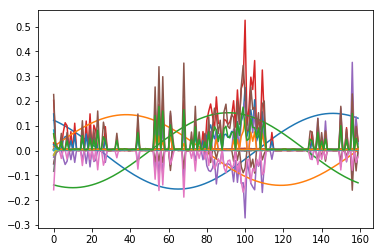

In [6]:
plt.plot(X[1//3, :, :])
plt.show()

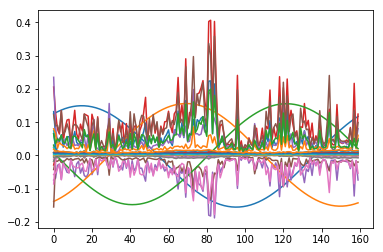

In [7]:
plt.plot(X_test_input[0, :, :])
plt.show()

### 最初の系列を除外

In [8]:
n_remove = 10
X = X[:, n_remove:, :]
X_test_input = X_test_input[:, n_remove:, :]
X.shape, X_test_input.shape

((2904, 150, 33), (6779, 150, 33))

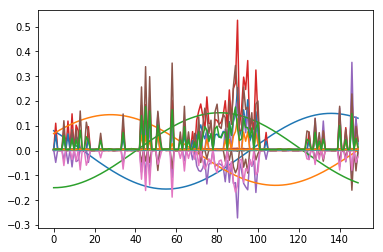

In [9]:
plt.plot(X[1//3, :, :])
plt.show()

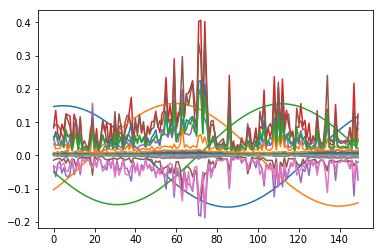

In [10]:
plt.plot(X_test_input[0, :, :])
plt.show()

### add features（使わない！）

In [126]:
import tsfresh

def entropy_and_fractal_dim(x):
    fe_list = [
        perm_entropy(x),
        svd_entropy(x),
        #app_entropy(x),
        #sample_entropy(x),
        petrosian_fd(x),
        katz_fd(x),
        higuchi_fd(x),
        tsfresh.feature_extraction.feature_calculators.c3(x, lag=100),   # non-linearity
        tsfresh.feature_extraction.feature_calculators.cid_ce(x, normalize=False)  # complexity
    ]
    return fe_list

In [127]:
def get_features_(dataset='train', split_parts=10):
    if dataset == 'train':
        meta_file = '../data/input/metadata_train.csv'
    elif dataset == 'test':
        meta_file = '../data/input/metadata_test.csv'

    meta_df = pd.read_csv(meta_file)

    data_measurements = meta_df.pivot(
        index='id_measurement', columns='phase', values='signal_id'
    )
    data_measurements = data_measurements.values
    data_measurements = np.array_split(data_measurements, split_parts, axis=0)
    X = Parallel(n_jobs=min(split_parts, MAX_THREADS), verbose=1)(delayed(prep_data_)(p, dataset) for p in data_measurements)
    X = np.concatenate(X, axis=0)

    return X

In [128]:
def transform_ts_(ts, n_dim=160, min_max=(-1,1)):
    # denoised
    ts_denoised = denoise_signal(ts, wavelet='db4', level=1)
    ts_denoised = min_max_transf(ts_denoised, min_data=min_num, max_data=max_num)
    fe_list = entropy_and_fractal_dim(ts_denoised)
    return np.asarray(fe_list)

In [129]:
def prep_data_(signal_ids, dataset="train"):
    signal_ids_all = np.concatenate(signal_ids)
    if dataset == "train":
        praq_data = pq.read_pandas('../data/input/train.parquet', columns=[str(i) for i in signal_ids_all]).to_pandas()
    elif dataset == "test":
        praq_data = pq.read_pandas('../data/input/test.parquet', columns=[str(i) for i in signal_ids_all]).to_pandas()
    else:
        raise ValueError("Unknown dataset")
    X = []
    for sids in signal_ids:
        data = praq_data[[str(s) for s in sids]].values.T
        X_signal = [transform_ts_(signal) for signal in data]
        X_signal = np.concatenate(X_signal, axis=0)
        X.append(X_signal)
    X = np.asarray(X)
    return X

In [131]:
X_add = get_features_("train", split_parts=8)
print(X_add.shape)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  7.1min remaining: 21.4min


(2904, 21)


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  7.5min finished


In [140]:
np.save(save_dir + "X_add.npy", X_add)
X_add = np.load(save_dir + "X_add.npy")
X_add.shape

(2904, 21)

### set model

In [11]:
# https://www.kaggle.com/suicaokhoailang/lstm-attention-baseline-0-652-lb

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [12]:
"""
def model_lstm(input_shape):
    inp = Input(shape=(input_shape[1], input_shape[2],))
    x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(inp)
    x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
    x = Attention(input_shape[1])(x)
    x = Dense(64, activation="relu")(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    
    return model
"""
def model_lstm(input_shape):
    inp = Input(shape=(input_shape[1], input_shape[2],))
    x = Conv1D(32, 8, padding='same',name='Conv1')(inp)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.2)(x)
    x = Conv1D(64, 5, padding='same',name='Conv2')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.2)(x)
    x = Conv1D(32, 3, padding='same',name='Conv5')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(64, activation='relu',name='features')(x)
    out = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=out)
    return model

In [13]:
def matthews_correlation(y_true, y_pred):
    '''Calculates the Matthews correlation coefficient measure for quality
    of binary classification problems.
    '''
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

### train adversal validation

In [ ]:
X_total = np.concatenate((X, X_test_input))
y_total = np.ones(len(X_total))
y_total[:len(X)] = 0

plt.plot(y_total)
plt.show()
X_total.shape, y_total.shape, y_total.sum()

In [ ]:
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
class roc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(self.x)
        roc = roc_auc_score(self.y, y_pred)
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)), str(round(roc_val,4))), end=100*' '+'\n')
        logs['val_auc'] = roc_val
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

In [ ]:
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X_total, y_total))
preds_val = []
y_val = []

for idx, (train_idx, val_idx) in enumerate(splits):
    K.clear_session()
    print("Beginning fold {}".format(idx+1))
    train_X, train_y, val_X, val_y = X_total[train_idx], y_total[train_idx], X_total[val_idx], y_total[val_idx]
    model = model_lstm(train_X.shape)
    optimizer = Adam(lr=1e-3)
    model.compile(optimizer=optimizer, loss='binary_crossentropy')
    ckpt = ModelCheckpoint(
        save_dir + 'weights_{}.h5'.format(idx), save_best_only=True,
        save_weights_only=True, verbose=1, monitor='val_auc', mode='max'
    )
    roc_auc = roc_callback(training_data=(train_X, train_y), validation_data=(val_X, val_y))
    early_stopping = EarlyStopping(monitor='val_auc', patience=5, mode="max")

    model.fit(
        train_X, train_y, batch_size=128, epochs=100,
        validation_data=[val_X, val_y], callbacks=[roc_auc, ckpt, early_stopping]
    )
    
    model.load_weights(save_dir + 'weights_{}.h5'.format(idx))
    preds_val.append(model.predict(val_X, batch_size=512))
    y_val.append(val_y)

preds_val = np.concatenate(preds_val)[...,0]
y_val = np.concatenate(y_val)
preds_val.shape, y_val.shape

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, preds_val)

In [ ]:
target = np.ones(len(X_total))
target = target * -1
target[:len(y)] = y
target.shape, target[target != -1].sum(), y.sum()

In [ ]:
val_idx_list = []
for idx, (train_idx, val_idx) in enumerate(splits):
    val_idx_list.append(val_idx)
val_idx_list = np.concatenate(val_idx_list)

In [ ]:
result = []
for idx, preds, test_flg in zip(val_idx_list, preds_val, y_val):
    result.append((idx, preds, test_flg))

result = pd.DataFrame(result, columns=["idx", "preds", "test_flg"])
result = result.sort_values("idx").reset_index(drop=True)
result["target"] = target
result.head()

In [ ]:
# check
print(result.query("test_flg == 0").target.sum())
result[["target", "test_flg"]].plot()
plt.show()
result.query("test_flg == 0").preds.hist()
plt.show()
result.query("test_flg == 1").preds.hist()
plt.show()

In [ ]:
result.to_csv(save_dir + "adversarial_validation_result.csv", index=False, header=True)

### get adversal validation result

In [ ]:
ad_result = pd.read_csv(save_dir + "adversarial_validation_result.csv")
ad_train = ad_result.query("test_flg == 0")
print(ad_train.test_flg.sum(), ad_train.target.sum(), y.sum())
ad_train.head()

In [ ]:
plt.hist(ad_train.query("target == 0")["preds"].values, bins=np.arange(0, 1.1, 0.1))
plt.hist(ad_train.query("target == 1")["preds"].values, bins=np.arange(0, 1.1, 0.1))
plt.show()

In [ ]:
# cut adversarial probabilities (for train) in 5 buckets
adver_idx_08_to_1 = ad_train.query("preds >= 0.80").idx.tolist()
adver_idx_06_to_08 = ad_train.query("0.80 > preds >= 0.60").idx.tolist()
adver_idx_04_to_06 = ad_train.query("0.60 > preds >= 0.40").idx.tolist()
adver_idx_02_to_04 = ad_train.query("0.40 > preds >= 0.20").idx.tolist()
adver_idx_00_to_02 = ad_train.query("0.20 > preds >= 0.00").idx.tolist()

print(len(adver_idx_08_to_1), len(adver_idx_06_to_08), len(adver_idx_04_to_06), len(adver_idx_02_to_04), len(adver_idx_00_to_02))
print(len(adver_idx_08_to_1)+len(adver_idx_06_to_08)+len(adver_idx_04_to_06)+len(adver_idx_02_to_04)+len(adver_idx_00_to_02))
print(len(y))

print(y[adver_idx_08_to_1].sum(), y[adver_idx_06_to_08].sum(), y[adver_idx_04_to_06].sum(), y[adver_idx_02_to_04].sum(), y[adver_idx_00_to_02].sum())
print(y[adver_idx_08_to_1].sum()+y[adver_idx_06_to_08].sum()+y[adver_idx_04_to_06].sum()+y[adver_idx_02_to_04].sum()+y[adver_idx_00_to_02].sum())
print(y.sum())

In [ ]:
adver_idx_08_to_1_pos = ad_train.query("preds >= 0.80 & target == 1").idx.tolist()
adver_idx_06_to_08_pos = ad_train.query("0.80 > preds >= 0.60 & target == 1").idx.tolist()
adver_idx_04_to_06_pos = ad_train.query("0.60 > preds >= 0.40 & target == 1").idx.tolist()
adver_idx_02_to_04_pos = ad_train.query("0.40 > preds >= 0.20 & target == 1").idx.tolist()
adver_idx_00_to_02_pos = ad_train.query("0.20 > preds >= 0.00 & target == 1").idx.tolist()

print(len(adver_idx_08_to_1_pos), len(adver_idx_06_to_08_pos), len(adver_idx_04_to_06_pos), len(adver_idx_02_to_04_pos), len(adver_idx_00_to_02_pos))
print(len(adver_idx_08_to_1_pos)+len(adver_idx_06_to_08_pos)+len(adver_idx_04_to_06_pos)+len(adver_idx_02_to_04_pos)+len(adver_idx_00_to_02_pos))
print(len(y))

In [ ]:
fold_index = np.zeros(len(y))
fold_index[adver_idx_08_to_1] = 1
fold_index[adver_idx_08_to_1_pos] = 2
fold_index[adver_idx_06_to_08] = 3
fold_index[adver_idx_06_to_08_pos] = 4
fold_index[adver_idx_04_to_06] = 5
fold_index[adver_idx_04_to_06_pos] = 6
fold_index[adver_idx_02_to_04] = 7
fold_index[adver_idx_02_to_04_pos] = 8
fold_index[adver_idx_00_to_02] = 9
fold_index[adver_idx_00_to_02_pos] = 10

print(len(fold_index[fold_index==1]), len(fold_index[fold_index==2]), len(fold_index[fold_index==1])+len(fold_index[fold_index==2]))
print(len(fold_index[fold_index==3]), len(fold_index[fold_index==4]), len(fold_index[fold_index==3])+len(fold_index[fold_index==4]))
print(len(fold_index[fold_index==5]), len(fold_index[fold_index==6]), len(fold_index[fold_index==5])+len(fold_index[fold_index==6]))
print(len(fold_index[fold_index==7]), len(fold_index[fold_index==8]), len(fold_index[fold_index==7])+len(fold_index[fold_index==8]))
print(len(fold_index[fold_index==9]), len(fold_index[fold_index==10]), len(fold_index[fold_index==9])+len(fold_index[fold_index==10]))

### train

In [14]:
best_thr_list = []
best_score_list = []
preds_val_list = []

def threshold_search(y_true, y_proba):
    thresholds = np.linspace(0.0, 1.0, 101)
    scores = [matthews_corrcoef(y_true, (y_proba > t).astype(np.uint8)) for t in thresholds]
    best_idx = np.argmax(scores)
    return thresholds[best_idx], scores[best_idx]

In [18]:
def train_per_fold(n_train, idx, train_X, train_y, val_X, val_y):
    model = model_lstm(train_X.shape)
    optimizer = Adam(lr=1e-3)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[matthews_correlation])
    save_model_name = f'weights_{n_train}_{idx}.h5'
    ckpt = ModelCheckpoint(
        save_dir + save_model_name, save_best_only=True,
        save_weights_only=True, verbose=1, monitor='val_matthews_correlation', mode='max'
    )    
    model.fit(
        train_X, train_y, batch_size=128, epochs=30, verbose=1,
        validation_data=[val_X, val_y], callbacks=[ckpt]
    )

    model.load_weights(save_dir + save_model_name)
    preds_train = np.squeeze(model.predict(train_X, batch_size=512))
    preds_val = np.squeeze(model.predict(val_X, batch_size=512))
    preds_test = np.squeeze(model.predict(X_test_input, batch_size=300, verbose=1))

    return preds_train, preds_val, preds_test

In [19]:
fold_index = y

In [20]:
splits = list(StratifiedKFold(
    n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, fold_index))

for n_train in range(N_TRAIN):
    print(f"===== n_train = {n_train} =====")

    for idx, (train_idx, val_idx) in enumerate(splits):
        K.clear_session()
        print("Beginning fold {}".format(idx+1))
        train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]        
        preds_train, preds_val, preds_test = train_per_fold(n_train, idx, train_X, train_y, val_X, val_y)
        np.save(save_dir + f"preds_train_{n_train}_{idx}.npy", preds_train)
        np.save(save_dir + f"preds_val_{n_train}_{idx}.npy", preds_val)
        np.save(save_dir + f"preds_test_{n_train}_{idx}.npy", preds_test)

        print("train result:", threshold_search(train_y, preds_train))
        print("val result:", threshold_search(val_y, preds_val))

===== n_train = 0 =====
Beginning fold 1
Train on 2323 samples, validate on 581 samples
Epoch 1/30
2323/2323 [==============================] - 2s 658us/step - loss: 0.2336 - matthews_correlation: 0.0154 - val_loss: 0.1816 - val_matthews_correlation: 0.1982

Epoch 00001: val_matthews_correlation improved from -inf to 0.19825, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.38/weights_0_0.h5
Epoch 2/30
2323/2323 [==============================] - 0s 107us/step - loss: 0.1595 - matthews_correlation: 0.1233 - val_loss: 0.1475 - val_matthews_correlation: 0.2292

Epoch 00002: val_matthews_correlation improved from 0.19825 to 0.22917, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.38/weights_0_0.h5
Epoch 3/30
2323/2323 [==============================] - 0s 106us/step - loss: 0.1306 - matthews_correlation: 0.4190 - val_loss: 0.1390 - val_matthews_correlation: 0.2411

Epoch 00003: val_matthews_correlation improved from 0.22917 to 0.24106, saving model to 

/home/hakubishin3/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


train result: (0.35000000000000003, 0.7932835746206822)
val result: (0.49, 0.7908515646309541)
Beginning fold 2
Train on 2323 samples, validate on 581 samples
Epoch 1/30
2323/2323 [==============================] - 1s 615us/step - loss: 0.2256 - matthews_correlation: -0.0039 - val_loss: 0.1717 - val_matthews_correlation: 0.0586

Epoch 00001: val_matthews_correlation improved from -inf to 0.05862, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.38/weights_0_1.h5
Epoch 2/30
2323/2323 [==============================] - 0s 107us/step - loss: 0.1345 - matthews_correlation: 0.2798 - val_loss: 0.1464 - val_matthews_correlation: 0.1714

Epoch 00002: val_matthews_correlation improved from 0.05862 to 0.17141, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.38/weights_0_1.h5
Epoch 3/30
2323/2323 [==============================] - 0s 106us/step - loss: 0.1139 - matthews_correlation: 0.5376 - val_loss: 0.1452 - val_matthews_correlation: 0.2322

Epoch 00003: val


Epoch 00030: val_matthews_correlation improved from 0.65141 to 0.67056, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.38/weights_0_1.h5
6779/6779 [==============================] - 0s 25us/step
train result: (0.41000000000000003, 0.7978743426271512)
val result: (0.5, 0.7073421771463073)
Beginning fold 3
Train on 2323 samples, validate on 581 samples
Epoch 1/30
2323/2323 [==============================] - 1s 602us/step - loss: 0.2705 - matthews_correlation: -0.0109 - val_loss: 0.1721 - val_matthews_correlation: 0.2374

Epoch 00001: val_matthews_correlation improved from -inf to 0.23740, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.38/weights_0_2.h5
Epoch 2/30
2323/2323 [==============================] - 0s 103us/step - loss: 0.1685 - matthews_correlation: 0.1873 - val_loss: 0.1360 - val_matthews_correlation: 0.2719

Epoch 00002: val_matthews_correlation improved from 0.23740 to 0.27190, saving model to ./save/kernel_5-fold_LSTM_with_threshold_


Epoch 00029: val_matthews_correlation improved from 0.77297 to 0.78593, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.38/weights_0_2.h5
Epoch 30/30
2323/2323 [==============================] - 0s 102us/step - loss: 0.0792 - matthews_correlation: 0.7135 - val_loss: 0.0915 - val_matthews_correlation: 0.7238

Epoch 00030: val_matthews_correlation did not improve from 0.78593
6779/6779 [==============================] - 0s 28us/step
train result: (0.41000000000000003, 0.7895215854742174)
val result: (0.46, 0.7997979262851159)
Beginning fold 4
Train on 2323 samples, validate on 581 samples
Epoch 1/30
2323/2323 [==============================] - 1s 599us/step - loss: 0.2269 - matthews_correlation: 0.0505 - val_loss: 0.1809 - val_matthews_correlation: 0.1363

Epoch 00001: val_matthews_correlation improved from -inf to 0.13631, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.38/weights_0_3.h5
Epoch 2/30
2323/2323 [==============================] - 0s 10

2324/2324 [==============================] - 0s 99us/step - loss: 0.1025 - matthews_correlation: 0.6381 - val_loss: 0.1417 - val_matthews_correlation: 0.5121

Epoch 00027: val_matthews_correlation did not improve from 0.72539
Epoch 28/30
2324/2324 [==============================] - 0s 101us/step - loss: 0.0975 - matthews_correlation: 0.6402 - val_loss: 0.1276 - val_matthews_correlation: 0.6390

Epoch 00028: val_matthews_correlation did not improve from 0.72539
Epoch 29/30
2324/2324 [==============================] - 0s 103us/step - loss: 0.0863 - matthews_correlation: 0.7056 - val_loss: 0.1010 - val_matthews_correlation: 0.6903

Epoch 00029: val_matthews_correlation did not improve from 0.72539
Epoch 30/30
2324/2324 [==============================] - 0s 101us/step - loss: 0.0828 - matthews_correlation: 0.7271 - val_loss: 0.0989 - val_matthews_correlation: 0.6824

Epoch 00030: val_matthews_correlation did not improve from 0.72539
6779/6779 [==============================] - 0s 27us/step

2323/2323 [==============================] - 0s 108us/step - loss: 0.0843 - matthews_correlation: 0.7144 - val_loss: 0.0963 - val_matthews_correlation: 0.6877

Epoch 00026: val_matthews_correlation did not improve from 0.78561
Epoch 27/30
2323/2323 [==============================] - 0s 107us/step - loss: 0.0871 - matthews_correlation: 0.6542 - val_loss: 0.0828 - val_matthews_correlation: 0.7068

Epoch 00027: val_matthews_correlation did not improve from 0.78561
Epoch 28/30
2323/2323 [==============================] - 0s 105us/step - loss: 0.0916 - matthews_correlation: 0.6841 - val_loss: 0.0950 - val_matthews_correlation: 0.6697

Epoch 00028: val_matthews_correlation did not improve from 0.78561
Epoch 29/30
2323/2323 [==============================] - 0s 104us/step - loss: 0.0812 - matthews_correlation: 0.7030 - val_loss: 0.0994 - val_matthews_correlation: 0.5263

Epoch 00029: val_matthews_correlation did not improve from 0.78561
Epoch 30/30
2323/2323 [==============================] -

2323/2323 [==============================] - 0s 103us/step - loss: 0.0779 - matthews_correlation: 0.7302 - val_loss: 0.1126 - val_matthews_correlation: 0.6215

Epoch 00026: val_matthews_correlation improved from 0.59108 to 0.62147, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.38/weights_1_1.h5
Epoch 27/30
2323/2323 [==============================] - 0s 105us/step - loss: 0.0829 - matthews_correlation: 0.6969 - val_loss: 0.1135 - val_matthews_correlation: 0.6322

Epoch 00027: val_matthews_correlation improved from 0.62147 to 0.63217, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.38/weights_1_1.h5
Epoch 28/30
2323/2323 [==============================] - 0s 104us/step - loss: 0.0813 - matthews_correlation: 0.7337 - val_loss: 0.1097 - val_matthews_correlation: 0.6322

Epoch 00028: val_matthews_correlation did not improve from 0.63217
Epoch 29/30
2323/2323 [==============================] - 0s 101us/step - loss: 0.0772 - matthews_correlation: 0.673


Epoch 00024: val_matthews_correlation improved from 0.79744 to 0.82344, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.38/weights_1_2.h5
Epoch 25/30
2323/2323 [==============================] - 0s 108us/step - loss: 0.0948 - matthews_correlation: 0.6085 - val_loss: 0.1299 - val_matthews_correlation: 0.7074

Epoch 00025: val_matthews_correlation did not improve from 0.82344
Epoch 26/30
2323/2323 [==============================] - 0s 106us/step - loss: 0.0872 - matthews_correlation: 0.6432 - val_loss: 0.0904 - val_matthews_correlation: 0.7755

Epoch 00026: val_matthews_correlation did not improve from 0.82344
Epoch 27/30
2323/2323 [==============================] - 0s 108us/step - loss: 0.0826 - matthews_correlation: 0.6794 - val_loss: 0.0798 - val_matthews_correlation: 0.7703

Epoch 00027: val_matthews_correlation did not improve from 0.82344
Epoch 28/30
2323/2323 [==============================] - 0s 105us/step - loss: 0.0790 - matthews_correlation: 0.7122 - val_lo

2323/2323 [==============================] - 0s 109us/step - loss: 0.0764 - matthews_correlation: 0.7328 - val_loss: 0.1290 - val_matthews_correlation: 0.5959

Epoch 00025: val_matthews_correlation did not improve from 0.64391
Epoch 26/30
2323/2323 [==============================] - 0s 108us/step - loss: 0.0783 - matthews_correlation: 0.7332 - val_loss: 0.1596 - val_matthews_correlation: 0.5769

Epoch 00026: val_matthews_correlation did not improve from 0.64391
Epoch 27/30
2323/2323 [==============================] - 0s 110us/step - loss: 0.0718 - matthews_correlation: 0.6992 - val_loss: 0.1385 - val_matthews_correlation: 0.5991

Epoch 00027: val_matthews_correlation did not improve from 0.64391
Epoch 28/30
2323/2323 [==============================] - 0s 110us/step - loss: 0.0768 - matthews_correlation: 0.7414 - val_loss: 0.1369 - val_matthews_correlation: 0.5645

Epoch 00028: val_matthews_correlation did not improve from 0.64391
Epoch 29/30
2323/2323 [==============================] -

2323/2323 [==============================] - 0s 102us/step - loss: 0.0909 - matthews_correlation: 0.6423 - val_loss: 0.0902 - val_matthews_correlation: 0.6541

Epoch 00026: val_matthews_correlation did not improve from 0.70630
Epoch 27/30
2323/2323 [==============================] - 0s 99us/step - loss: 0.0838 - matthews_correlation: 0.7008 - val_loss: 0.0934 - val_matthews_correlation: 0.7061

Epoch 00027: val_matthews_correlation did not improve from 0.70630
Epoch 28/30
2323/2323 [==============================] - 0s 99us/step - loss: 0.0805 - matthews_correlation: 0.6871 - val_loss: 0.1158 - val_matthews_correlation: 0.6414

Epoch 00028: val_matthews_correlation did not improve from 0.70630
Epoch 29/30
2323/2323 [==============================] - 0s 97us/step - loss: 0.0837 - matthews_correlation: 0.7342 - val_loss: 0.0928 - val_matthews_correlation: 0.6696

Epoch 00029: val_matthews_correlation did not improve from 0.70630
Epoch 30/30
2323/2323 [==============================] - 0s

2323/2323 [==============================] - 0s 105us/step - loss: 0.0871 - matthews_correlation: 0.6919 - val_loss: 0.1036 - val_matthews_correlation: 0.5877

Epoch 00027: val_matthews_correlation improved from 0.57787 to 0.58772, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.38/weights_2_1.h5
Epoch 28/30
2323/2323 [==============================] - 0s 105us/step - loss: 0.0849 - matthews_correlation: 0.7052 - val_loss: 0.1200 - val_matthews_correlation: 0.6093

Epoch 00028: val_matthews_correlation improved from 0.58772 to 0.60931, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.38/weights_2_1.h5
Epoch 29/30
2323/2323 [==============================] - 0s 104us/step - loss: 0.0831 - matthews_correlation: 0.6823 - val_loss: 0.1178 - val_matthews_correlation: 0.6060

Epoch 00029: val_matthews_correlation did not improve from 0.60931
Epoch 30/30
2323/2323 [==============================] - 0s 105us/step - loss: 0.0809 - matthews_correlation: 0.696


Epoch 00025: val_matthews_correlation did not improve from 0.78741
Epoch 26/30
2323/2323 [==============================] - 0s 99us/step - loss: 0.0926 - matthews_correlation: 0.6390 - val_loss: 0.1305 - val_matthews_correlation: 0.6890

Epoch 00026: val_matthews_correlation did not improve from 0.78741
Epoch 27/30
2323/2323 [==============================] - 0s 102us/step - loss: 0.0887 - matthews_correlation: 0.6906 - val_loss: 0.1050 - val_matthews_correlation: 0.7334

Epoch 00027: val_matthews_correlation did not improve from 0.78741
Epoch 28/30
2323/2323 [==============================] - 0s 102us/step - loss: 0.0827 - matthews_correlation: 0.7289 - val_loss: 0.0931 - val_matthews_correlation: 0.7552

Epoch 00028: val_matthews_correlation did not improve from 0.78741
Epoch 29/30
2323/2323 [==============================] - 0s 102us/step - loss: 0.0911 - matthews_correlation: 0.6553 - val_loss: 0.1002 - val_matthews_correlation: 0.7366

Epoch 00029: val_matthews_correlation did no

2323/2323 [==============================] - 0s 103us/step - loss: 0.0745 - matthews_correlation: 0.7368 - val_loss: 0.1416 - val_matthews_correlation: 0.5099

Epoch 00027: val_matthews_correlation did not improve from 0.65076
Epoch 28/30
2323/2323 [==============================] - 0s 101us/step - loss: 0.0723 - matthews_correlation: 0.7678 - val_loss: 0.1289 - val_matthews_correlation: 0.5786

Epoch 00028: val_matthews_correlation did not improve from 0.65076
Epoch 29/30
2323/2323 [==============================] - 0s 100us/step - loss: 0.0721 - matthews_correlation: 0.7517 - val_loss: 0.1391 - val_matthews_correlation: 0.6118

Epoch 00029: val_matthews_correlation did not improve from 0.65076
Epoch 30/30
2323/2323 [==============================] - 0s 101us/step - loss: 0.0681 - matthews_correlation: 0.7765 - val_loss: 0.1318 - val_matthews_correlation: 0.5977

Epoch 00030: val_matthews_correlation did not improve from 0.65076
6779/6779 [==============================] - 0s 27us/ste


Epoch 00026: val_matthews_correlation did not improve from 0.77289
Epoch 27/30
2323/2323 [==============================] - 0s 100us/step - loss: 0.0865 - matthews_correlation: 0.6665 - val_loss: 0.0984 - val_matthews_correlation: 0.6763

Epoch 00027: val_matthews_correlation did not improve from 0.77289
Epoch 28/30
2323/2323 [==============================] - 0s 104us/step - loss: 0.0824 - matthews_correlation: 0.7013 - val_loss: 0.0929 - val_matthews_correlation: 0.6732

Epoch 00028: val_matthews_correlation did not improve from 0.77289
Epoch 29/30
2323/2323 [==============================] - 0s 104us/step - loss: 0.0804 - matthews_correlation: 0.7625 - val_loss: 0.0904 - val_matthews_correlation: 0.6971

Epoch 00029: val_matthews_correlation did not improve from 0.77289
Epoch 30/30
2323/2323 [==============================] - 0s 104us/step - loss: 0.0799 - matthews_correlation: 0.7015 - val_loss: 0.0954 - val_matthews_correlation: 0.6859

Epoch 00030: val_matthews_correlation did n

2323/2323 [==============================] - 0s 102us/step - loss: 0.0753 - matthews_correlation: 0.6979 - val_loss: 0.1141 - val_matthews_correlation: 0.6338

Epoch 00027: val_matthews_correlation did not improve from 0.68583
Epoch 28/30
2323/2323 [==============================] - 0s 103us/step - loss: 0.0768 - matthews_correlation: 0.7297 - val_loss: 0.1108 - val_matthews_correlation: 0.6314

Epoch 00028: val_matthews_correlation did not improve from 0.68583
Epoch 29/30
2323/2323 [==============================] - 0s 106us/step - loss: 0.0803 - matthews_correlation: 0.7053 - val_loss: 0.1092 - val_matthews_correlation: 0.6507

Epoch 00029: val_matthews_correlation did not improve from 0.68583
Epoch 30/30
2323/2323 [==============================] - 0s 103us/step - loss: 0.0788 - matthews_correlation: 0.7250 - val_loss: 0.1070 - val_matthews_correlation: 0.6584

Epoch 00030: val_matthews_correlation did not improve from 0.68583
6779/6779 [==============================] - 0s 27us/ste

2323/2323 [==============================] - 0s 101us/step - loss: 0.0865 - matthews_correlation: 0.6624 - val_loss: 0.0772 - val_matthews_correlation: 0.7907

Epoch 00028: val_matthews_correlation did not improve from 0.79140
Epoch 29/30
2323/2323 [==============================] - 0s 101us/step - loss: 0.0886 - matthews_correlation: 0.6966 - val_loss: 0.0859 - val_matthews_correlation: 0.7313

Epoch 00029: val_matthews_correlation did not improve from 0.79140
Epoch 30/30
2323/2323 [==============================] - 0s 102us/step - loss: 0.0805 - matthews_correlation: 0.7132 - val_loss: 0.0707 - val_matthews_correlation: 0.8301

Epoch 00030: val_matthews_correlation improved from 0.79140 to 0.83011, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.38/weights_3_2.h5
6779/6779 [==============================] - 0s 28us/step
train result: (0.5, 0.7940441109416309)
val result: (0.53, 0.8350840232010744)
Beginning fold 4
Train on 2323 samples, validate on 581 samples
Epoc

2324/2324 [==============================] - 0s 97us/step - loss: 0.0899 - matthews_correlation: 0.6997 - val_loss: 0.1004 - val_matthews_correlation: 0.7130

Epoch 00028: val_matthews_correlation did not improve from 0.79671
Epoch 29/30
2324/2324 [==============================] - 0s 99us/step - loss: 0.0764 - matthews_correlation: 0.7507 - val_loss: 0.1210 - val_matthews_correlation: 0.6662

Epoch 00029: val_matthews_correlation did not improve from 0.79671
Epoch 30/30
2324/2324 [==============================] - 0s 99us/step - loss: 0.0816 - matthews_correlation: 0.7115 - val_loss: 0.0827 - val_matthews_correlation: 0.7257

Epoch 00030: val_matthews_correlation did not improve from 0.79671
6779/6779 [==============================] - 0s 27us/step
train result: (0.41000000000000003, 0.691966283317181)
val result: (0.49, 0.7871559633027523)
===== n_train = 4 =====
Beginning fold 1
Train on 2323 samples, validate on 581 samples
Epoch 1/30
2323/2323 [==============================] - 1s

2323/2323 [==============================] - 0s 108us/step - loss: 0.0778 - matthews_correlation: 0.7061 - val_loss: 0.1087 - val_matthews_correlation: 0.6441

Epoch 00027: val_matthews_correlation improved from 0.62402 to 0.64407, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.38/weights_4_1.h5
Epoch 28/30
2323/2323 [==============================] - 0s 111us/step - loss: 0.0795 - matthews_correlation: 0.6544 - val_loss: 0.1095 - val_matthews_correlation: 0.4901

Epoch 00028: val_matthews_correlation did not improve from 0.64407
Epoch 29/30
2323/2323 [==============================] - 0s 111us/step - loss: 0.0778 - matthews_correlation: 0.7301 - val_loss: 0.1165 - val_matthews_correlation: 0.6029

Epoch 00029: val_matthews_correlation did not improve from 0.64407
Epoch 30/30
2323/2323 [==============================] - 0s 108us/step - loss: 0.0803 - matthews_correlation: 0.7063 - val_loss: 0.1046 - val_matthews_correlation: 0.5756

Epoch 00030: val_matthews_correla


Epoch 00027: val_matthews_correlation improved from 0.75896 to 0.78748, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.38/weights_4_2.h5
Epoch 28/30
2323/2323 [==============================] - 0s 102us/step - loss: 0.0849 - matthews_correlation: 0.6796 - val_loss: 0.0897 - val_matthews_correlation: 0.7399

Epoch 00028: val_matthews_correlation did not improve from 0.78748
Epoch 29/30
2323/2323 [==============================] - 0s 106us/step - loss: 0.0919 - matthews_correlation: 0.6501 - val_loss: 0.0945 - val_matthews_correlation: 0.7746

Epoch 00029: val_matthews_correlation did not improve from 0.78748
Epoch 30/30
2323/2323 [==============================] - 0s 103us/step - loss: 0.0886 - matthews_correlation: 0.6639 - val_loss: 0.0970 - val_matthews_correlation: 0.7146

Epoch 00030: val_matthews_correlation did not improve from 0.78748
6779/6779 [==============================] - 0s 28us/step
train result: (0.51, 0.7492833718061795)
val result: (0.58, 0.79085


Epoch 00028: val_matthews_correlation did not improve from 0.62612
Epoch 29/30
2323/2323 [==============================] - 0s 98us/step - loss: 0.0746 - matthews_correlation: 0.7347 - val_loss: 0.1145 - val_matthews_correlation: 0.6107

Epoch 00029: val_matthews_correlation did not improve from 0.62612
Epoch 30/30
2323/2323 [==============================] - 0s 99us/step - loss: 0.0710 - matthews_correlation: 0.7074 - val_loss: 0.1149 - val_matthews_correlation: 0.6591

Epoch 00030: val_matthews_correlation improved from 0.62612 to 0.65906, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.38/weights_4_3.h5
6779/6779 [==============================] - 0s 25us/step
train result: (0.44, 0.828822445747853)
val result: (0.53, 0.7059886831662752)
Beginning fold 5
Train on 2324 samples, validate on 580 samples
Epoch 1/30
2324/2324 [==============================] - 1s 599us/step - loss: 1.1725 - matthews_correlation: -0.0239 - val_loss: 0.3143 - val_matthews_correlation: 0

2324/2324 [==============================] - 0s 100us/step - loss: 0.0831 - matthews_correlation: 0.7084 - val_loss: 0.0986 - val_matthews_correlation: 0.6206

Epoch 00027: val_matthews_correlation did not improve from 0.70938
Epoch 28/30
2324/2324 [==============================] - 0s 99us/step - loss: 0.0907 - matthews_correlation: 0.6719 - val_loss: 0.0932 - val_matthews_correlation: 0.7225

Epoch 00028: val_matthews_correlation improved from 0.70938 to 0.72247, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.38/weights_4_4.h5
Epoch 29/30
2324/2324 [==============================] - 0s 104us/step - loss: 0.0833 - matthews_correlation: 0.7267 - val_loss: 0.0881 - val_matthews_correlation: 0.7347

Epoch 00029: val_matthews_correlation improved from 0.72247 to 0.73474, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.38/weights_4_4.h5
Epoch 30/30
2324/2324 [==============================] - 0s 103us/step - loss: 0.0859 - matthews_correlation: 0.7145

2323/2323 [==============================] - 0s 99us/step - loss: 0.0745 - matthews_correlation: 0.7360 - val_loss: 0.1064 - val_matthews_correlation: 0.5650

Epoch 00026: val_matthews_correlation did not improve from 0.60756
Epoch 27/30
2323/2323 [==============================] - 0s 96us/step - loss: 0.0874 - matthews_correlation: 0.6813 - val_loss: 0.1462 - val_matthews_correlation: 0.6321

Epoch 00027: val_matthews_correlation improved from 0.60756 to 0.63206, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.38/weights_5_1.h5
Epoch 28/30
2323/2323 [==============================] - 0s 101us/step - loss: 0.0790 - matthews_correlation: 0.7114 - val_loss: 0.1110 - val_matthews_correlation: 0.6207

Epoch 00028: val_matthews_correlation did not improve from 0.63206
Epoch 29/30
2323/2323 [==============================] - 0s 99us/step - loss: 0.0786 - matthews_correlation: 0.6819 - val_loss: 0.1326 - val_matthews_correlation: 0.6527

Epoch 00029: val_matthews_correlatio

2323/2323 [==============================] - 0s 106us/step - loss: 0.0797 - matthews_correlation: 0.6680 - val_loss: 0.1352 - val_matthews_correlation: 0.5800

Epoch 00025: val_matthews_correlation did not improve from 0.60778
Epoch 26/30
2323/2323 [==============================] - 0s 106us/step - loss: 0.0768 - matthews_correlation: 0.7294 - val_loss: 0.1307 - val_matthews_correlation: 0.5578

Epoch 00026: val_matthews_correlation did not improve from 0.60778
Epoch 27/30
2323/2323 [==============================] - 0s 103us/step - loss: 0.0732 - matthews_correlation: 0.7728 - val_loss: 0.1320 - val_matthews_correlation: 0.5432

Epoch 00027: val_matthews_correlation did not improve from 0.60778
Epoch 28/30
2323/2323 [==============================] - 0s 104us/step - loss: 0.0688 - matthews_correlation: 0.7580 - val_loss: 0.1484 - val_matthews_correlation: 0.6158

Epoch 00028: val_matthews_correlation improved from 0.60778 to 0.61584, saving model to ./save/kernel_5-fold_LSTM_with_thre

2324/2324 [==============================] - 0s 102us/step - loss: 0.0916 - matthews_correlation: 0.6996 - val_loss: 0.1250 - val_matthews_correlation: 0.5964

Epoch 00024: val_matthews_correlation did not improve from 0.71024
Epoch 25/30
2324/2324 [==============================] - 0s 102us/step - loss: 0.0958 - matthews_correlation: 0.6581 - val_loss: 0.1300 - val_matthews_correlation: 0.5993

Epoch 00025: val_matthews_correlation did not improve from 0.71024
Epoch 26/30
2324/2324 [==============================] - 0s 102us/step - loss: 0.0835 - matthews_correlation: 0.6810 - val_loss: 0.1090 - val_matthews_correlation: 0.6751

Epoch 00026: val_matthews_correlation did not improve from 0.71024
Epoch 27/30
2324/2324 [==============================] - 0s 101us/step - loss: 0.0861 - matthews_correlation: 0.6845 - val_loss: 0.1131 - val_matthews_correlation: 0.6673

Epoch 00027: val_matthews_correlation did not improve from 0.71024
Epoch 28/30
2324/2324 [==============================] -

2323/2323 [==============================] - 0s 101us/step - loss: 0.0835 - matthews_correlation: 0.7236 - val_loss: 0.1111 - val_matthews_correlation: 0.4365

Epoch 00024: val_matthews_correlation did not improve from 0.62028
Epoch 25/30
2323/2323 [==============================] - 0s 100us/step - loss: 0.0906 - matthews_correlation: 0.6731 - val_loss: 0.1055 - val_matthews_correlation: 0.5460

Epoch 00025: val_matthews_correlation did not improve from 0.62028
Epoch 26/30
2323/2323 [==============================] - 0s 103us/step - loss: 0.0801 - matthews_correlation: 0.7352 - val_loss: 0.1029 - val_matthews_correlation: 0.5896

Epoch 00026: val_matthews_correlation did not improve from 0.62028
Epoch 27/30
2323/2323 [==============================] - 0s 102us/step - loss: 0.0785 - matthews_correlation: 0.7252 - val_loss: 0.1045 - val_matthews_correlation: 0.5801

Epoch 00027: val_matthews_correlation did not improve from 0.62028
Epoch 28/30
2323/2323 [==============================] -


Epoch 00024: val_matthews_correlation did not improve from 0.77435
Epoch 25/30
2323/2323 [==============================] - 0s 98us/step - loss: 0.0932 - matthews_correlation: 0.6229 - val_loss: 0.0811 - val_matthews_correlation: 0.7295

Epoch 00025: val_matthews_correlation did not improve from 0.77435
Epoch 26/30
2323/2323 [==============================] - 0s 101us/step - loss: 0.0875 - matthews_correlation: 0.6500 - val_loss: 0.0791 - val_matthews_correlation: 0.8075

Epoch 00026: val_matthews_correlation improved from 0.77435 to 0.80755, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.38/weights_6_2.h5
Epoch 27/30
2323/2323 [==============================] - 0s 99us/step - loss: 0.0821 - matthews_correlation: 0.6705 - val_loss: 0.0785 - val_matthews_correlation: 0.7916

Epoch 00027: val_matthews_correlation did not improve from 0.80755
Epoch 28/30
2323/2323 [==============================] - 0s 101us/step - loss: 0.0785 - matthews_correlation: 0.6845 - val_loss


Epoch 00025: val_matthews_correlation improved from 0.56054 to 0.60571, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.38/weights_6_3.h5
Epoch 26/30
2323/2323 [==============================] - 0s 111us/step - loss: 0.0817 - matthews_correlation: 0.6893 - val_loss: 0.1309 - val_matthews_correlation: 0.5943

Epoch 00026: val_matthews_correlation did not improve from 0.60571
Epoch 27/30
2323/2323 [==============================] - 0s 110us/step - loss: 0.0826 - matthews_correlation: 0.6788 - val_loss: 0.1328 - val_matthews_correlation: 0.5424

Epoch 00027: val_matthews_correlation did not improve from 0.60571
Epoch 28/30
2323/2323 [==============================] - 0s 113us/step - loss: 0.0758 - matthews_correlation: 0.7214 - val_loss: 0.1524 - val_matthews_correlation: 0.6045

Epoch 00028: val_matthews_correlation did not improve from 0.60571
Epoch 29/30
2323/2323 [==============================] - 0s 111us/step - loss: 0.0777 - matthews_correlation: 0.7238 - val_lo

2323/2323 [==============================] - 0s 102us/step - loss: 0.0852 - matthews_correlation: 0.6588 - val_loss: 0.0974 - val_matthews_correlation: 0.7056

Epoch 00026: val_matthews_correlation did not improve from 0.72704
Epoch 27/30
2323/2323 [==============================] - 0s 101us/step - loss: 0.0847 - matthews_correlation: 0.7136 - val_loss: 0.1006 - val_matthews_correlation: 0.6996

Epoch 00027: val_matthews_correlation did not improve from 0.72704
Epoch 28/30
2323/2323 [==============================] - 0s 98us/step - loss: 0.0842 - matthews_correlation: 0.7263 - val_loss: 0.0949 - val_matthews_correlation: 0.7184

Epoch 00028: val_matthews_correlation did not improve from 0.72704
Epoch 29/30
2323/2323 [==============================] - 0s 99us/step - loss: 0.0788 - matthews_correlation: 0.7144 - val_loss: 0.1022 - val_matthews_correlation: 0.6746

Epoch 00029: val_matthews_correlation did not improve from 0.72704
Epoch 30/30
2323/2323 [==============================] - 0


Epoch 00026: val_matthews_correlation did not improve from 0.62675
Epoch 27/30
2323/2323 [==============================] - 0s 110us/step - loss: 0.0812 - matthews_correlation: 0.7133 - val_loss: 0.1049 - val_matthews_correlation: 0.5590

Epoch 00027: val_matthews_correlation did not improve from 0.62675
Epoch 28/30
2323/2323 [==============================] - 0s 109us/step - loss: 0.0786 - matthews_correlation: 0.7327 - val_loss: 0.1145 - val_matthews_correlation: 0.4927

Epoch 00028: val_matthews_correlation did not improve from 0.62675
Epoch 29/30
2323/2323 [==============================] - 0s 104us/step - loss: 0.0776 - matthews_correlation: 0.7056 - val_loss: 0.1077 - val_matthews_correlation: 0.5932

Epoch 00029: val_matthews_correlation did not improve from 0.62675
Epoch 30/30
2323/2323 [==============================] - 0s 102us/step - loss: 0.0771 - matthews_correlation: 0.7205 - val_loss: 0.1070 - val_matthews_correlation: 0.6285

Epoch 00030: val_matthews_correlation impro


Epoch 00027: val_matthews_correlation did not improve from 0.74992
Epoch 28/30
2323/2323 [==============================] - 0s 100us/step - loss: 0.0837 - matthews_correlation: 0.6812 - val_loss: 0.1061 - val_matthews_correlation: 0.7560

Epoch 00028: val_matthews_correlation improved from 0.74992 to 0.75599, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.38/weights_7_2.h5
Epoch 29/30
2323/2323 [==============================] - 0s 99us/step - loss: 0.0876 - matthews_correlation: 0.6562 - val_loss: 0.1039 - val_matthews_correlation: 0.7508

Epoch 00029: val_matthews_correlation did not improve from 0.75599
Epoch 30/30
2323/2323 [==============================] - 0s 100us/step - loss: 0.0845 - matthews_correlation: 0.6942 - val_loss: 0.0851 - val_matthews_correlation: 0.7126

Epoch 00030: val_matthews_correlation did not improve from 0.75599
6779/6779 [==============================] - 0s 26us/step
train result: (0.6900000000000001, 0.7521400939667845)
val result: (

2324/2324 [==============================] - 0s 100us/step - loss: 0.0822 - matthews_correlation: 0.7233 - val_loss: 0.0983 - val_matthews_correlation: 0.6684

Epoch 00029: val_matthews_correlation did not improve from 0.73338
Epoch 30/30
2324/2324 [==============================] - 0s 105us/step - loss: 0.0772 - matthews_correlation: 0.7208 - val_loss: 0.1026 - val_matthews_correlation: 0.6895

Epoch 00030: val_matthews_correlation did not improve from 0.73338
6779/6779 [==============================] - 0s 27us/step
train result: (0.5, 0.736900657446045)
val result: (0.48, 0.7337913368882756)
===== n_train = 8 =====
Beginning fold 1
Train on 2323 samples, validate on 581 samples
Epoch 1/30
2323/2323 [==============================] - 1s 593us/step - loss: 0.2373 - matthews_correlation: 0.0184 - val_loss: 0.1776 - val_matthews_correlation: 0.1787

Epoch 00001: val_matthews_correlation improved from -inf to 0.17870, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.38/

2323/2323 [==============================] - 0s 100us/step - loss: 0.0819 - matthews_correlation: 0.7343 - val_loss: 0.1076 - val_matthews_correlation: 0.5940

Epoch 00028: val_matthews_correlation did not improve from 0.70482
Epoch 29/30
2323/2323 [==============================] - 0s 100us/step - loss: 0.0801 - matthews_correlation: 0.7532 - val_loss: 0.1176 - val_matthews_correlation: 0.3317

Epoch 00029: val_matthews_correlation did not improve from 0.70482
Epoch 30/30
2323/2323 [==============================] - 0s 104us/step - loss: 0.0843 - matthews_correlation: 0.7112 - val_loss: 0.1062 - val_matthews_correlation: 0.3738

Epoch 00030: val_matthews_correlation did not improve from 0.70482
6779/6779 [==============================] - 0s 27us/step
train result: (0.47000000000000003, 0.7725142707655668)
val result: (0.47000000000000003, 0.7338216065631048)
Beginning fold 3
Train on 2323 samples, validate on 581 samples
Epoch 1/30
2323/2323 [==============================] - 1s 596u


Epoch 00026: val_matthews_correlation improved from 0.79368 to 0.80432, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.38/weights_8_2.h5
Epoch 27/30
2323/2323 [==============================] - 0s 99us/step - loss: 0.0876 - matthews_correlation: 0.6719 - val_loss: 0.0902 - val_matthews_correlation: 0.7419

Epoch 00027: val_matthews_correlation did not improve from 0.80432
Epoch 28/30
2323/2323 [==============================] - 0s 101us/step - loss: 0.0831 - matthews_correlation: 0.6922 - val_loss: 0.0887 - val_matthews_correlation: 0.7592

Epoch 00028: val_matthews_correlation did not improve from 0.80432
Epoch 29/30
2323/2323 [==============================] - 0s 101us/step - loss: 0.0827 - matthews_correlation: 0.7075 - val_loss: 0.0834 - val_matthews_correlation: 0.7690

Epoch 00029: val_matthews_correlation did not improve from 0.80432
Epoch 30/30
2323/2323 [==============================] - 0s 99us/step - loss: 0.0804 - matthews_correlation: 0.7402 - val_loss

2323/2323 [==============================] - 0s 103us/step - loss: 0.0711 - matthews_correlation: 0.7122 - val_loss: 0.1263 - val_matthews_correlation: 0.5900

Epoch 00027: val_matthews_correlation did not improve from 0.60378
Epoch 28/30
2323/2323 [==============================] - 0s 108us/step - loss: 0.0741 - matthews_correlation: 0.7491 - val_loss: 0.1263 - val_matthews_correlation: 0.5570

Epoch 00028: val_matthews_correlation did not improve from 0.60378
Epoch 29/30
2323/2323 [==============================] - 0s 108us/step - loss: 0.0693 - matthews_correlation: 0.7431 - val_loss: 0.1274 - val_matthews_correlation: 0.5301

Epoch 00029: val_matthews_correlation did not improve from 0.60378
Epoch 30/30
2323/2323 [==============================] - 0s 107us/step - loss: 0.0711 - matthews_correlation: 0.7458 - val_loss: 0.1345 - val_matthews_correlation: 0.5364

Epoch 00030: val_matthews_correlation did not improve from 0.60378
6779/6779 [==============================] - 0s 26us/ste

2323/2323 [==============================] - 0s 100us/step - loss: 0.0798 - matthews_correlation: 0.7230 - val_loss: 0.1017 - val_matthews_correlation: 0.6208

Epoch 00027: val_matthews_correlation did not improve from 0.79266
Epoch 28/30
2323/2323 [==============================] - 0s 103us/step - loss: 0.0802 - matthews_correlation: 0.6916 - val_loss: 0.1023 - val_matthews_correlation: 0.7170

Epoch 00028: val_matthews_correlation did not improve from 0.79266
Epoch 29/30
2323/2323 [==============================] - 0s 100us/step - loss: 0.0824 - matthews_correlation: 0.7324 - val_loss: 0.0931 - val_matthews_correlation: 0.7624

Epoch 00029: val_matthews_correlation did not improve from 0.79266
Epoch 30/30
2323/2323 [==============================] - 0s 100us/step - loss: 0.0790 - matthews_correlation: 0.6781 - val_loss: 0.0950 - val_matthews_correlation: 0.6802

Epoch 00030: val_matthews_correlation did not improve from 0.79266
6779/6779 [==============================] - 0s 26us/ste


Epoch 00026: val_matthews_correlation did not improve from 0.80755
Epoch 27/30
2323/2323 [==============================] - 0s 101us/step - loss: 0.0833 - matthews_correlation: 0.7177 - val_loss: 0.0867 - val_matthews_correlation: 0.7485

Epoch 00027: val_matthews_correlation did not improve from 0.80755
Epoch 28/30
2323/2323 [==============================] - 0s 100us/step - loss: 0.0877 - matthews_correlation: 0.6849 - val_loss: 0.0796 - val_matthews_correlation: 0.7919

Epoch 00028: val_matthews_correlation did not improve from 0.80755
Epoch 29/30
2323/2323 [==============================] - 0s 101us/step - loss: 0.0799 - matthews_correlation: 0.7076 - val_loss: 0.0972 - val_matthews_correlation: 0.5375

Epoch 00029: val_matthews_correlation did not improve from 0.80755
Epoch 30/30
2323/2323 [==============================] - 0s 98us/step - loss: 0.0944 - matthews_correlation: 0.6691 - val_loss: 0.0936 - val_matthews_correlation: 0.7604

Epoch 00030: val_matthews_correlation did no

2323/2323 [==============================] - 0s 100us/step - loss: 0.0743 - matthews_correlation: 0.7211 - val_loss: 0.1270 - val_matthews_correlation: 0.5910

Epoch 00028: val_matthews_correlation improved from 0.58826 to 0.59097, saving model to ./save/kernel_5-fold_LSTM_with_threshold_tuning_v1.38/weights_9_3.h5
Epoch 29/30
2323/2323 [==============================] - 0s 100us/step - loss: 0.0751 - matthews_correlation: 0.6958 - val_loss: 0.1250 - val_matthews_correlation: 0.5545

Epoch 00029: val_matthews_correlation did not improve from 0.59097
Epoch 30/30
2323/2323 [==============================] - 0s 97us/step - loss: 0.0779 - matthews_correlation: 0.6891 - val_loss: 0.1547 - val_matthews_correlation: 0.5456

Epoch 00030: val_matthews_correlation did not improve from 0.59097
6779/6779 [==============================] - 0s 27us/step
train result: (0.5700000000000001, 0.7934166683171795)
val result: (0.29, 0.626000063517385)
Beginning fold 5
Train on 2324 samples, validate on 580

### check train result

#### (n_train, fold)単位で結果を出力

In [21]:
def plot_score(y_true, y_pred):
    thr_list = []
    score_list = []
    for thr in np.linspace(0.01, 0.99, 100):
        score = matthews_corrcoef(y_true.astype(np.float64), (y_pred > thr).astype(np.float64))
        score_list.append(score)
        thr_list.append(thr)

    plt.plot(score_list)
    plt.show()

===== n_train = 0 =====
Beginning fold 1


/home/hakubishin3/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


train result: (0.35000000000000003, 0.7932835746206822)
val result: (0.49, 0.7908515646309541)


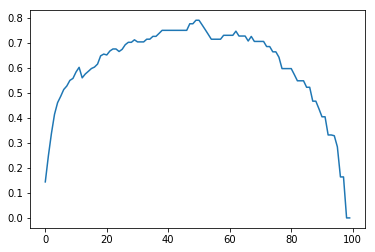

Beginning fold 2
train result: (0.41000000000000003, 0.7978743426271512)
val result: (0.5, 0.7073421771463073)


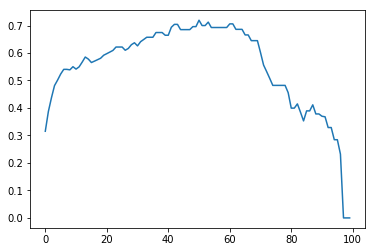

Beginning fold 3
train result: (0.41000000000000003, 0.7895215854742174)
val result: (0.46, 0.7997979262851159)


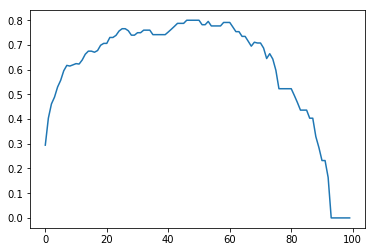

Beginning fold 4
train result: (0.28, 0.7597728896974332)
val result: (0.5, 0.6663985474826788)


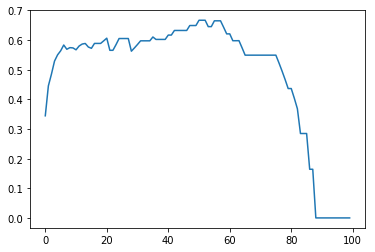

Beginning fold 5
train result: (0.45, 0.7826583291926947)
val result: (0.49, 0.7263433813892529)


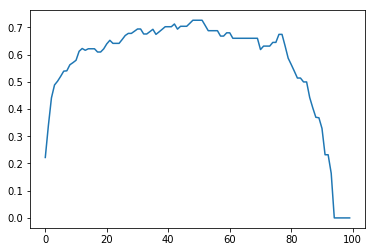

===== n_train = 1 =====
Beginning fold 1
train result: (0.24, 0.7589920032675467)
val result: (0.47000000000000003, 0.7874211660104642)


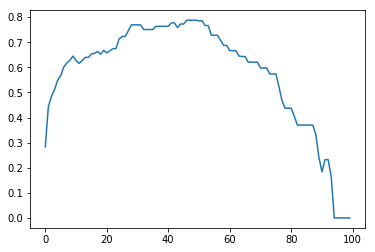

Beginning fold 2
train result: (0.42, 0.776677923221278)
val result: (0.36, 0.6801975978259015)


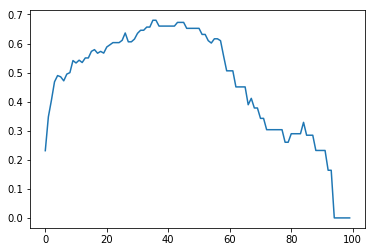

Beginning fold 3
train result: (0.55, 0.7582672577989757)
val result: (0.53, 0.8523180916695984)


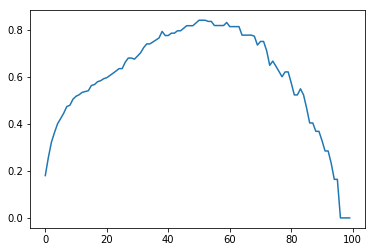

Beginning fold 4
train result: (0.61, 0.7817080035554069)
val result: (0.49, 0.6646318226373823)


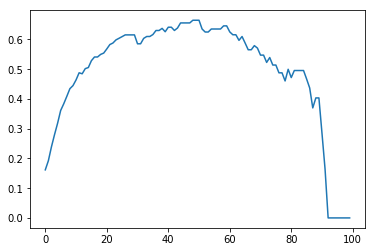

Beginning fold 5
train result: (0.55, 0.7862768797342835)
val result: (0.5, 0.7125591976939062)


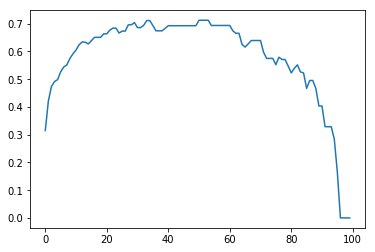

===== n_train = 2 =====
Beginning fold 1
train result: (0.35000000000000003, 0.7386463504084073)
val result: (0.41000000000000003, 0.7581619830251926)


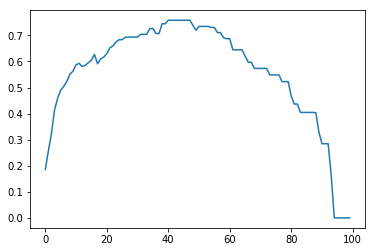

Beginning fold 2
train result: (0.59, 0.775067357834061)
val result: (0.44, 0.6759095255609106)


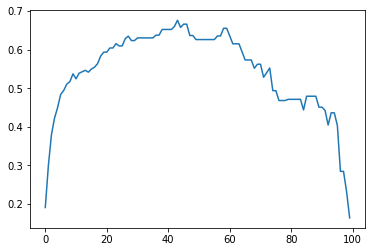

Beginning fold 3
train result: (0.54, 0.7459926056627605)
val result: (0.56, 0.8129673230810819)


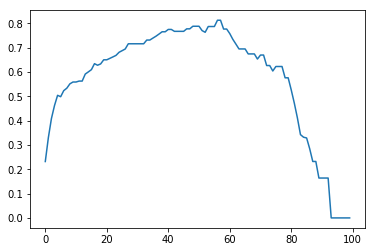

Beginning fold 4
train result: (0.32, 0.7920829069722096)
val result: (0.47000000000000003, 0.6727703947860026)


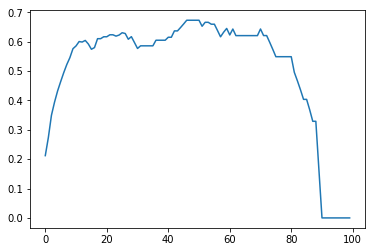

Beginning fold 5
train result: (0.61, 0.7950210272370206)
val result: (0.59, 0.7775894123496468)


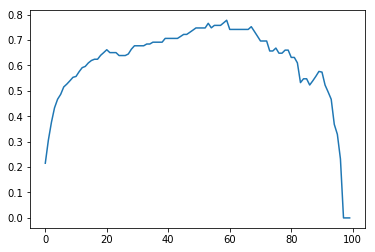

===== n_train = 3 =====
Beginning fold 1
train result: (0.38, 0.7940441109416309)
val result: (0.44, 0.7908515646309541)


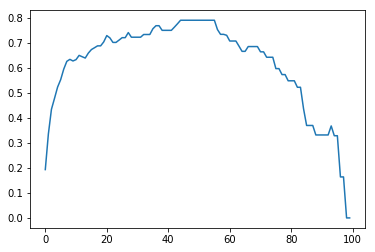

Beginning fold 2
train result: (0.56, 0.7940441109416309)
val result: (0.49, 0.725472401419431)


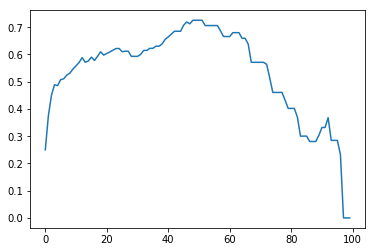

Beginning fold 3
train result: (0.5, 0.7940441109416309)
val result: (0.53, 0.8350840232010744)


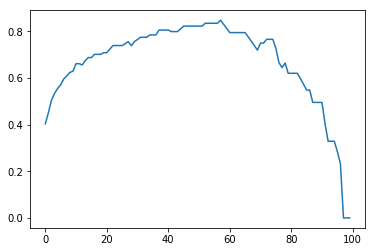

Beginning fold 4
train result: (0.44, 0.7780478199700528)
val result: (0.44, 0.6927828198136694)


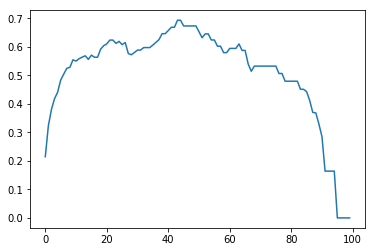

Beginning fold 5
train result: (0.41000000000000003, 0.691966283317181)
val result: (0.49, 0.7871559633027523)


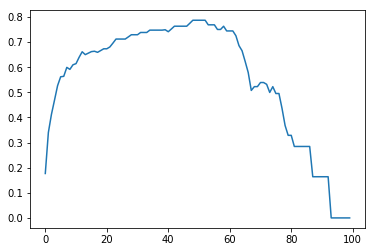

===== n_train = 4 =====
Beginning fold 1
train result: (0.34, 0.7125843483801567)
val result: (0.45, 0.7767592864568306)


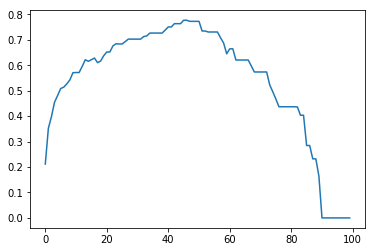

Beginning fold 2
train result: (0.38, 0.7961302064559261)
val result: (0.51, 0.6927828198136694)


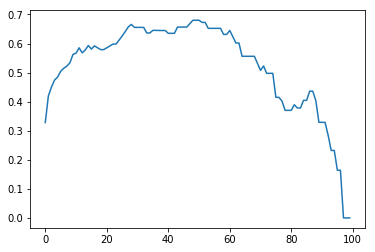

Beginning fold 3
train result: (0.51, 0.7492833718061795)
val result: (0.58, 0.7908515646309541)


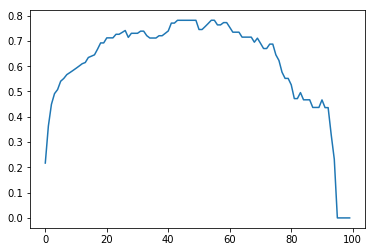

Beginning fold 4
train result: (0.44, 0.828822445747853)
val result: (0.53, 0.7059886831662752)


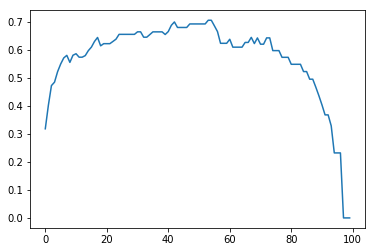

Beginning fold 5
train result: (0.51, 0.7568144789681371)
val result: (0.63, 0.7504336457374771)


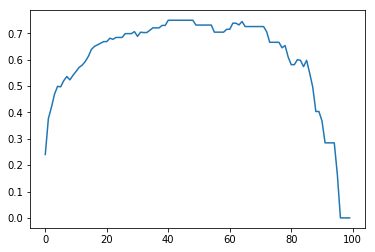

===== n_train = 5 =====
Beginning fold 1
train result: (0.36, 0.7480053236243084)
val result: (0.44, 0.7633118752616854)


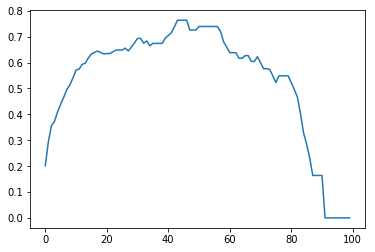

Beginning fold 2
train result: (0.71, 0.796160026780648)
val result: (0.65, 0.6850581056130026)


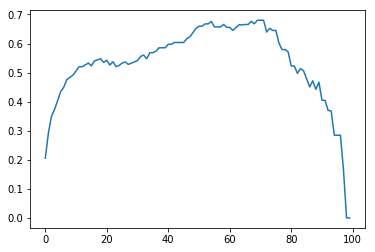

Beginning fold 3
train result: (0.56, 0.7317473000081662)
val result: (0.5, 0.8050788396834601)


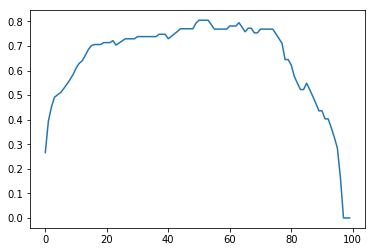

Beginning fold 4
train result: (0.6900000000000001, 0.8064623357121733)
val result: (0.5, 0.6520311282828876)


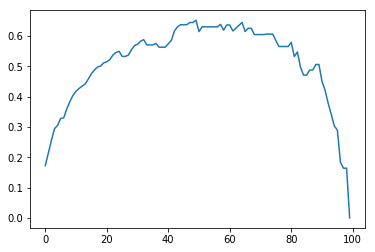

Beginning fold 5
train result: (0.49, 0.7629067536649092)
val result: (0.47000000000000003, 0.7150313268936217)


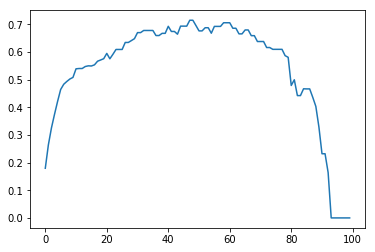

===== n_train = 6 =====
Beginning fold 1
train result: (0.27, 0.7159193222845556)
val result: (0.48, 0.7688521546555444)


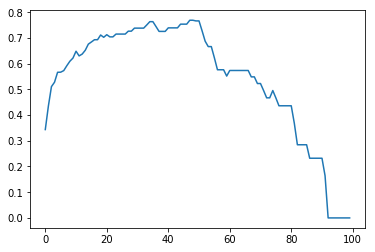

Beginning fold 2
train result: (0.61, 0.72703863176053)
val result: (0.52, 0.6384222112939232)


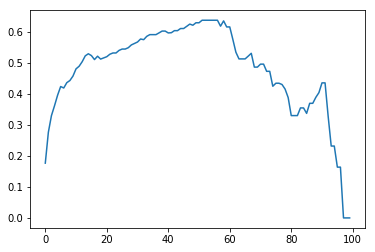

Beginning fold 3
train result: (0.56, 0.7667776095259647)
val result: (0.48, 0.8129673230810819)


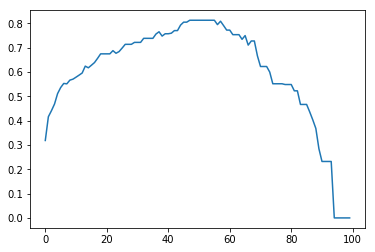

Beginning fold 4
train result: (0.71, 0.7900703699019942)
val result: (0.49, 0.6411786720368196)


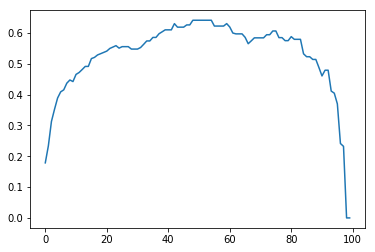

Beginning fold 5
train result: (0.67, 0.7918303486208101)
val result: (0.77, 0.7059596128393867)


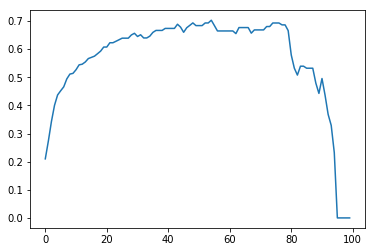

===== n_train = 7 =====
Beginning fold 1
train result: (0.32, 0.7079025364040378)
val result: (0.5, 0.7581619830251926)


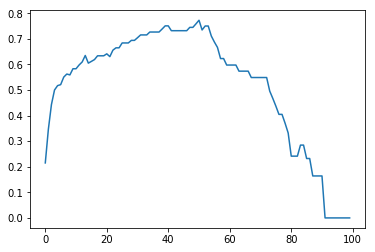

Beginning fold 2
train result: (0.5, 0.8144031108212468)
val result: (0.46, 0.6879533576976085)


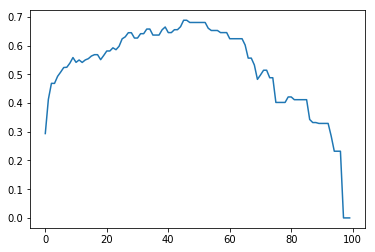

Beginning fold 3
train result: (0.6900000000000001, 0.7521400939667845)
val result: (0.52, 0.7655563044807264)


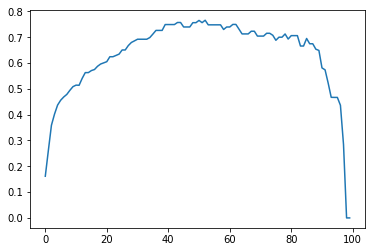

Beginning fold 4
train result: (0.31, 0.7363430745120169)
val result: (0.44, 0.6698546337593818)


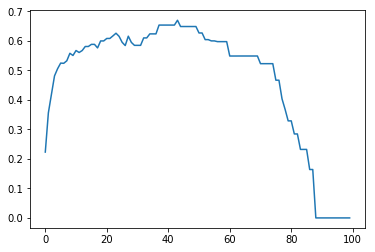

Beginning fold 5
train result: (0.5, 0.736900657446045)
val result: (0.48, 0.7337913368882756)


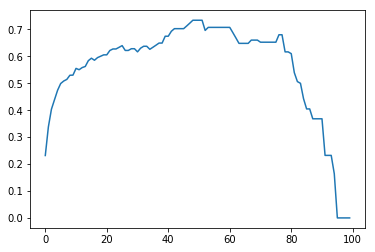

===== n_train = 8 =====
Beginning fold 1
train result: (0.35000000000000003, 0.7694961140215586)
val result: (0.52, 0.7908515646309541)


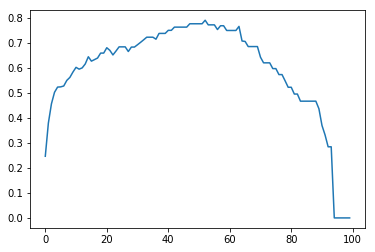

Beginning fold 2
train result: (0.47000000000000003, 0.7725142707655668)
val result: (0.47000000000000003, 0.7338216065631048)


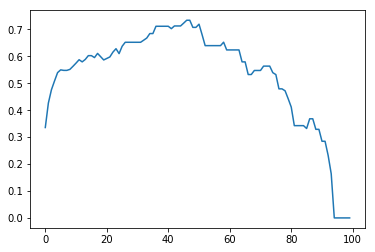

Beginning fold 3
train result: (0.37, 0.7393820056051341)
val result: (0.5, 0.7950210272370206)


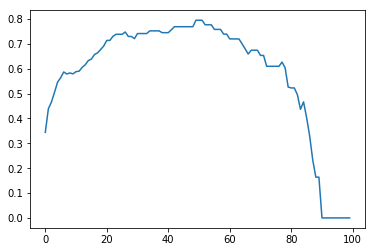

Beginning fold 4
train result: (0.38, 0.7504536758801654)
val result: (0.33, 0.6185427247213983)


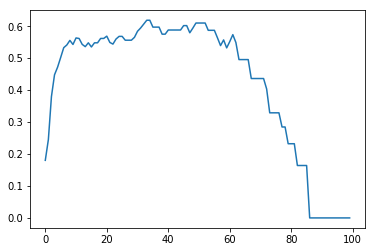

Beginning fold 5
train result: (0.32, 0.7539855229764933)
val result: (0.49, 0.694899177232132)


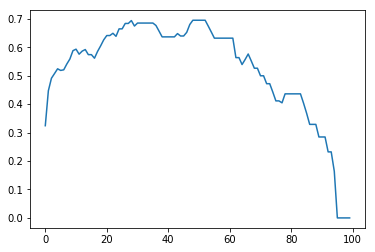

===== n_train = 9 =====
Beginning fold 1
train result: (0.4, 0.7473285361735567)
val result: (0.5, 0.805643548307093)


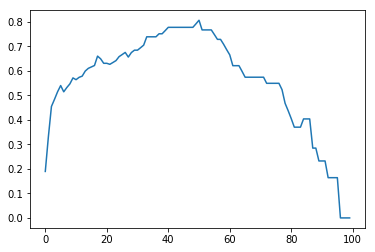

Beginning fold 2
train result: (0.55, 0.7985473920420078)
val result: (0.49, 0.6681844193356795)


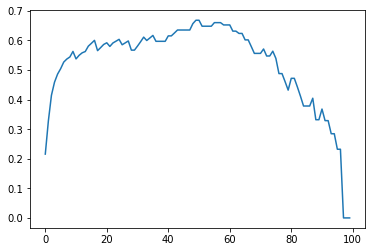

Beginning fold 3
train result: (0.34, 0.7225568155962949)
val result: (0.48, 0.8129673230810819)


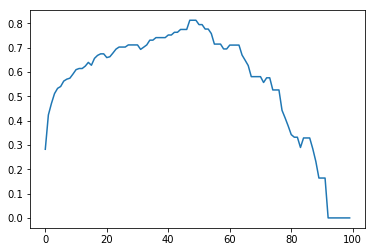

Beginning fold 4
train result: (0.5700000000000001, 0.7934166683171795)
val result: (0.29, 0.626000063517385)


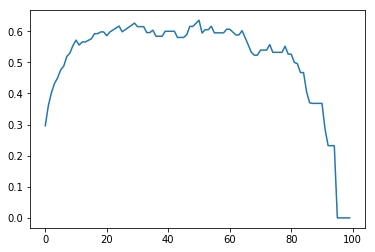

Beginning fold 5
train result: (0.49, 0.7795787545787546)
val result: (0.41000000000000003, 0.711396964093209)


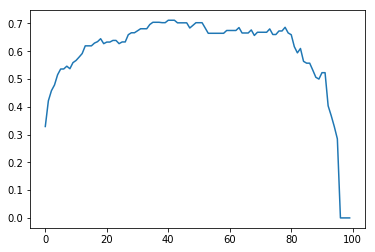

In [22]:
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, fold_index))

for n_train in range(N_TRAIN):
    print(f"===== n_train = {n_train} =====")
    for idx, (train_idx, val_idx) in enumerate(splits):
        print("Beginning fold {}".format(idx+1))   
        train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]
        preds_train = np.load(save_dir + f"preds_train_{n_train}_{idx}.npy")
        preds_val = np.load(save_dir + f"preds_val_{n_train}_{idx}.npy")

        print("train result:", threshold_search(train_y, preds_train))
        print("val result:", threshold_search(val_y, preds_val))
        plot_score(val_y, preds_val)

#### (n_train)単位で結果を出力

===== n_train = 0 =====
fold0 result: (0.49, 0.7908515646309541)


/home/hakubishin3/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


fold1 result: (0.5, 0.7073421771463073)
fold2 result: (0.46, 0.7997979262851159)
fold3 result: (0.5, 0.6663985474826788)
fold4 result: (0.49, 0.7263433813892529)
val result: (0.5, 0.7369713094492908)


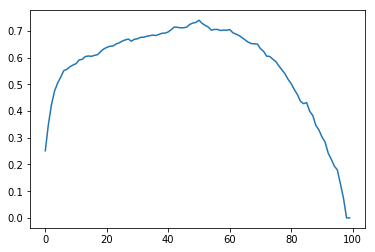

===== n_train = 1 =====
fold0 result: (0.47000000000000003, 0.7874211660104642)
fold1 result: (0.36, 0.6801975978259015)
fold2 result: (0.53, 0.8523180916695984)
fold3 result: (0.49, 0.6646318226373823)
fold4 result: (0.5, 0.7125591976939062)
val result: (0.5, 0.7263675862429985)


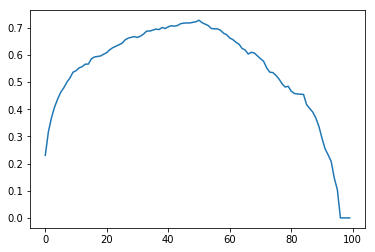

===== n_train = 2 =====
fold0 result: (0.41000000000000003, 0.7581619830251926)
fold1 result: (0.44, 0.6759095255609106)
fold2 result: (0.56, 0.8129673230810819)
fold3 result: (0.47000000000000003, 0.6727703947860026)
fold4 result: (0.59, 0.7775894123496468)
val result: (0.48, 0.7155143893817013)


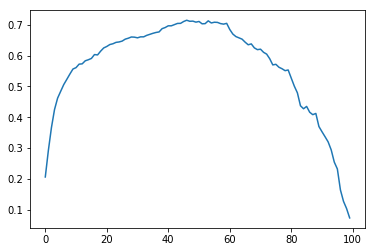

===== n_train = 3 =====
fold0 result: (0.44, 0.7908515646309541)
fold1 result: (0.49, 0.725472401419431)
fold2 result: (0.53, 0.8350840232010744)
fold3 result: (0.44, 0.6927828198136694)
fold4 result: (0.49, 0.7871559633027523)
val result: (0.49, 0.7606903340639469)


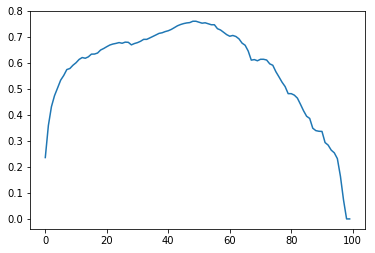

===== n_train = 4 =====
fold0 result: (0.45, 0.7767592864568306)
fold1 result: (0.51, 0.6927828198136694)
fold2 result: (0.58, 0.7908515646309541)
fold3 result: (0.53, 0.7059886831662752)
fold4 result: (0.63, 0.7504336457374771)
val result: (0.49, 0.7343919267870672)


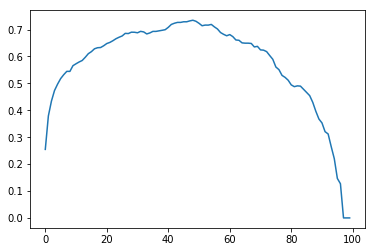

===== n_train = 5 =====
fold0 result: (0.44, 0.7633118752616854)
fold1 result: (0.65, 0.6850581056130026)
fold2 result: (0.5, 0.8050788396834601)
fold3 result: (0.5, 0.6520311282828876)
fold4 result: (0.47000000000000003, 0.7150313268936217)
val result: (0.5, 0.700780170628251)


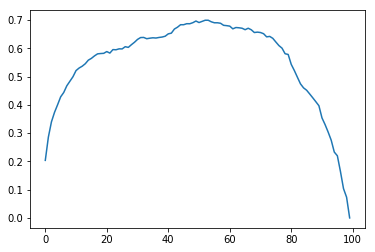

===== n_train = 6 =====
fold0 result: (0.48, 0.7688521546555444)
fold1 result: (0.52, 0.6384222112939232)
fold2 result: (0.48, 0.8129673230810819)
fold3 result: (0.49, 0.6411786720368196)
fold4 result: (0.77, 0.7059596128393867)
val result: (0.49, 0.6990135585653658)


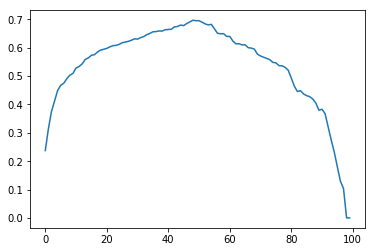

===== n_train = 7 =====
fold0 result: (0.5, 0.7581619830251926)
fold1 result: (0.46, 0.6879533576976085)
fold2 result: (0.52, 0.7655563044807264)
fold3 result: (0.44, 0.6698546337593818)
fold4 result: (0.48, 0.7337913368882756)
val result: (0.5, 0.7105535058899987)


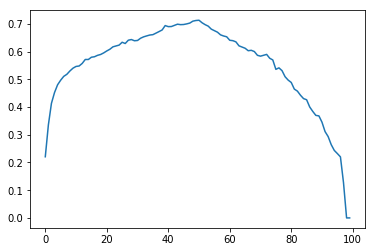

===== n_train = 8 =====
fold0 result: (0.52, 0.7908515646309541)
fold1 result: (0.47000000000000003, 0.7338216065631048)
fold2 result: (0.5, 0.7950210272370206)
fold3 result: (0.33, 0.6185427247213983)
fold4 result: (0.49, 0.694899177232132)
val result: (0.5, 0.7209369413404642)


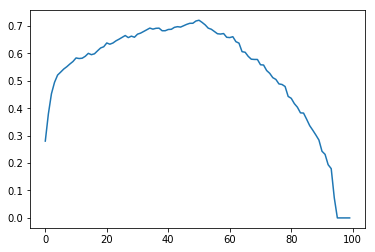

===== n_train = 9 =====
fold0 result: (0.5, 0.805643548307093)
fold1 result: (0.49, 0.6681844193356795)
fold2 result: (0.48, 0.8129673230810819)
fold3 result: (0.29, 0.626000063517385)
fold4 result: (0.41000000000000003, 0.711396964093209)
val result: (0.5, 0.7196635187263135)


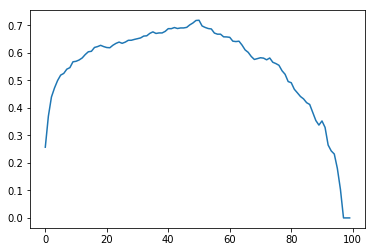

In [23]:
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, fold_index))

for n_train in range(N_TRAIN):
    print(f"===== n_train = {n_train} =====")
    preds_val_all = []
    y_val = []
    
    for idx, (train_idx, val_idx) in enumerate(splits):
        train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]
        preds_train = np.load(save_dir + f"preds_train_{n_train}_{idx}.npy")
        preds_val = np.load(save_dir + f"preds_val_{n_train}_{idx}.npy")
        preds_val_all.append(preds_val)
        y_val.append(val_y)
        print(f"fold{idx} result: {threshold_search(val_y, preds_val)}")

    y_val = np.concatenate(y_val)
    preds_val_all = np.concatenate(preds_val_all)

    print("val result:", threshold_search(y_val, preds_val_all))
    plot_score(y_val, preds_val_all)

### adversarial validation

In [34]:
ad_result = pd.read_csv(save_dir + "adversarial_validation_result.csv")
ad_train = ad_result.query("test_flg == 0").sort_values("idx")
ad_val_idx = ad_train.query("preds > 0.75").idx.values
len(ad_val_idx)

318

In [35]:
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, fold_index))

for n_train in range(N_TRAIN):
    print(f"===== n_train = {n_train} =====")
    preds_val_all = []
    y_val = []
    val_idx_list = []
    
    for idx, (train_idx, val_idx) in enumerate(splits):
        train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]
        preds_train = np.load(save_dir + f"preds_train_{n_train}_{idx}.npy")
        preds_val = np.load(save_dir + f"preds_val_{n_train}_{idx}.npy")
        preds_val_all.append(preds_val)
        y_val.append(val_y)
        val_idx_list.append(val_idx)
        print(f"fold{idx} result: {threshold_search(val_y, preds_val)}")

    y_val = np.concatenate(y_val)
    preds_val_all = np.concatenate(preds_val_all)
    val_idx_list = np.concatenate(val_idx_list)
    
    result_df = []
    for idx, target, preds in zip(val_idx_list, y_val, preds_val_all):
        result_df.append((idx, target, preds))
    result_df = pd.DataFrame(result_df, columns=["idx", "target", "preds"])
    result_df = result_df.sort_values("idx").reset_index(drop=True)
    extract = result_df.query("idx in @ad_val_idx")

    print("val result:", threshold_search(y_val, preds_val_all))
    print("adverl result:", threshold_search(extract.target.values, extract.preds.values))

===== n_train = 0 =====


/home/hakubishin3/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


fold0 result: (0.5700000000000001, 0.7601594864460611)
fold1 result: (0.6, 0.8223644119439366)
fold2 result: (0.46, 0.7828829514354293)
fold3 result: (0.36, 0.7137703636342039)
fold4 result: (0.34, 0.6973963048211226)
val result: (0.5700000000000001, 0.7357577704861323)
adverl result: (0.46, 0.5924082806203598)
===== n_train = 1 =====
fold0 result: (0.52, 0.7601594864460611)
fold1 result: (0.58, 0.7631525492585821)
fold2 result: (0.45, 0.732971967527029)
fold3 result: (0.5700000000000001, 0.7043363928829716)
fold4 result: (0.53, 0.6868371968164555)
val result: (0.52, 0.7183677021026861)
adverl result: (0.5, 0.6272209263704686)
===== n_train = 2 =====
fold0 result: (0.49, 0.7523772784651094)
fold1 result: (0.47000000000000003, 0.8051223219649741)
fold2 result: (0.49, 0.7941787301830776)
fold3 result: (0.54, 0.6754758691515832)
fold4 result: (0.5, 0.7190555176425457)
val result: (0.5, 0.7422619808008578)
adverl result: (0.5, 0.6072370954617966)
===== n_train = 3 =====
fold0 result: (0.51

### predict v1

- n_train = 2の予測を出力
- LB = 0.640, adverl_resultと似ている？

In [91]:
n_train = 0

In [92]:
preds_test = []
for idx in range(N_SPLITS):
    pred = np.load(save_dir + f"preds_test_{n_train}_{idx}.npy")
    pred_3 = []

    for pred_scalar in pred:
        for i in range(3):
            pred_3.append(pred_scalar)
    preds_test.append(pred_3)

In [93]:
best_threshold = 0.49
preds_test = (np.squeeze(np.mean(preds_test, axis=0)) > best_threshold).astype(np.int)
preds_test.shape

(20337,)

In [94]:
submission = pd.read_csv('../data/input/sample_submission.csv')
submission['target'] = preds_test
submission.to_csv(save_dir + 'submission_v1.csv', index=False)
submission.sum()

signal_id    383962560
target             777
dtype: int64

### predict v2

- 全ての(idx, fold)を足し合わせる

In [24]:
from sklearn.calibration import _SigmoidCalibration
from scipy.stats import rankdata

np.warnings.filterwarnings('ignore')
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, fold_index))
scores_all_fold_list = []
preds_val_all = []
y_val = []
val_idx_list = []

for idx, (train_idx, val_idx) in enumerate(splits):
    train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]

    scores_list = []
    preds_val_idx = np.zeros(len(val_y))
    for n_train in range(N_TRAIN):        
        preds_val = np.load(save_dir + f"preds_val_{n_train}_{idx}.npy")
        preds_test = np.load(save_dir + f"preds_test_{n_train}_{idx}.npy")
        preds_val_idx += preds_val / N_TRAIN

        score_list = []
        for thr in np.linspace(0.0, 1.0, 501):
            score = matthews_corrcoef(val_y, (preds_val > thr).astype(np.uint8))
            score_list.append(score)
        scores = np.asarray(score_list)
        scores_list.append(scores)
        
    scores_all_fold_list.append(scores_list)
    preds_val_all.append(preds_val_idx)
    y_val.append(val_y)
    val_idx_list.append(val_idx)
    print(threshold_search(val_y, preds_val_idx))
    
y_val = np.concatenate(y_val)
preds_val_all = np.concatenate(preds_val_all)
print("val result:", threshold_search(y_val, preds_val_all))

(0.51, 0.805643548307093)
(0.5700000000000001, 0.6860941012370246)
(0.48, 0.8175824175824176)
(0.35000000000000003, 0.6657643390221974)
(0.41000000000000003, 0.7393674436009183)
val result: (0.52, 0.7303801044114445)


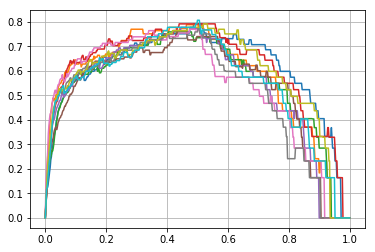

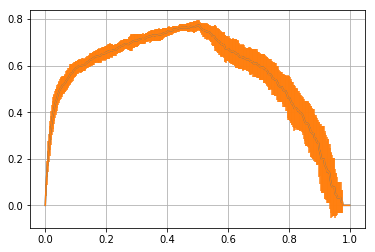

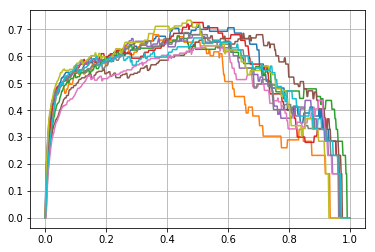

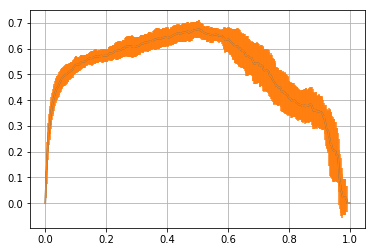

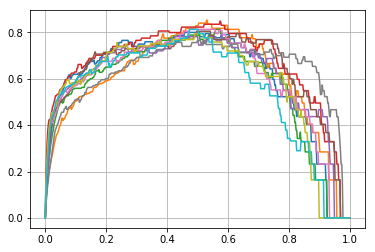

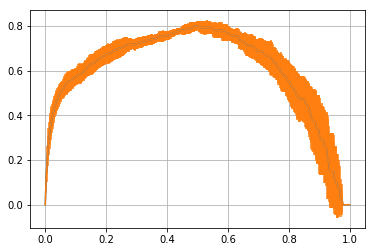

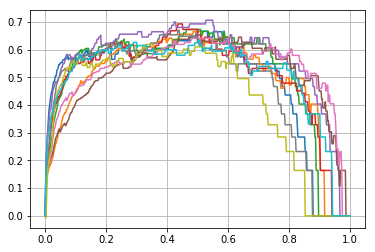

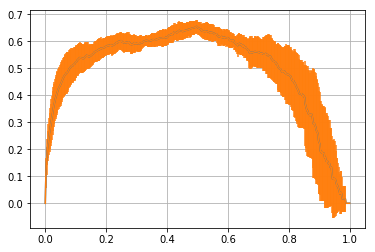

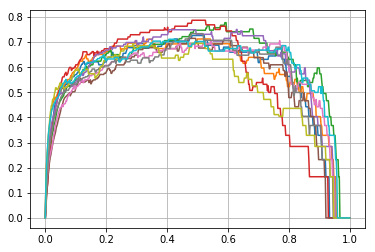

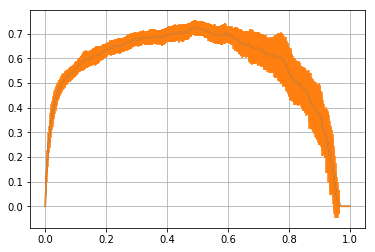

In [25]:
for scores_list in scores_all_fold_list:
    x_line = np.linspace(0.0, 1.0, 501)
    for n_train in range(N_TRAIN):
        plt.plot(x_line, scores_list[n_train])
    plt.grid()
    plt.show()

    mean = np.asarray(scores_list).mean(axis=0)
    std = np.asarray(scores_list).std(axis=0)
    plt.plot(x_line, mean)
    plt.errorbar(x_line, mean, yerr=std)
    plt.grid()
    plt.show()

### predict v3

- 全ての(idx, fold)をsigmoidにスケール変換
- 足し合わせて閾値を決める

In [26]:
from sklearn.calibration import _SigmoidCalibration
from scipy.stats import rankdata

np.warnings.filterwarnings('ignore')
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, fold_index))
scores_all_fold_list = []
preds_val_all = []
preds_test_all = []
y_val = []
val_idx_list = []

for idx, (train_idx, val_idx) in enumerate(splits):
    train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]
    scores_list = []
    preds_val_idx = np.zeros(len(val_y))
    preds_test_idx = np.zeros(len(X_test_input))
    
    for n_train in range(N_TRAIN):        
        preds_val = np.load(save_dir + f"preds_val_{n_train}_{idx}.npy")
        preds_test = np.load(save_dir + f"preds_test_{n_train}_{idx}.npy")
        calb = _SigmoidCalibration()
        calb.fit(preds_val, val_y)
        preds_val = calb.predict(preds_val)
        preds_test = calb.predict(preds_test)
        preds_val_idx += preds_val / N_TRAIN
        preds_test_idx += preds_test / N_TRAIN

        score_list = []
        for thr in np.linspace(0.0, 1.0, 501):
            score = matthews_corrcoef(val_y, (preds_val > thr).astype(np.uint8))
            score_list.append(score)
        scores = np.asarray(score_list)
        scores_list.append(scores)
        
    scores_all_fold_list.append(scores_list)
    preds_val_all.append(preds_val_idx)
    preds_test_all.append(preds_test_idx)
    y_val.append(val_y)
    val_idx_list.append(val_idx)
    print(threshold_search(val_y, preds_val_idx))
    
y_val = np.concatenate(y_val)
preds_val_all = np.concatenate(preds_val_all)
print("val result:", threshold_search(y_val, preds_val_all))

(0.51, 0.805643548307093)
(0.42, 0.6860941012370246)
(0.31, 0.8350840232010744)
(0.48, 0.6592781404553004)
(0.18, 0.7393674436009183)
val result: (0.48, 0.7259142508696129)


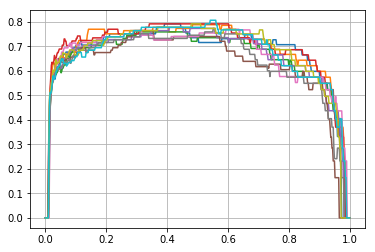

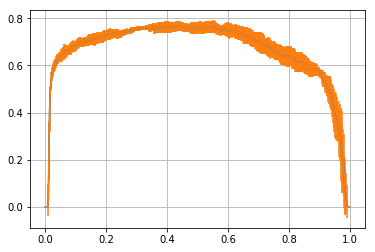

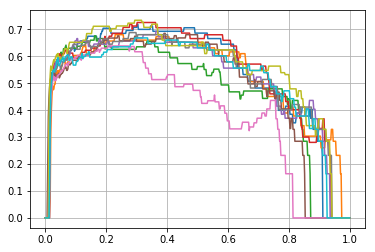

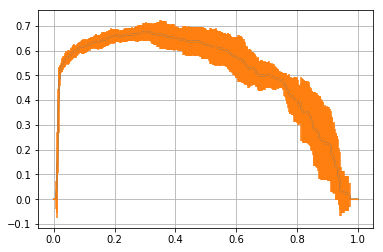

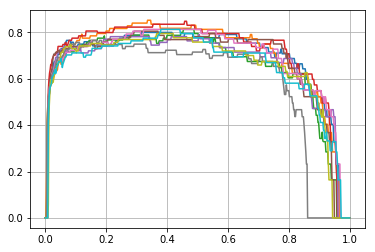

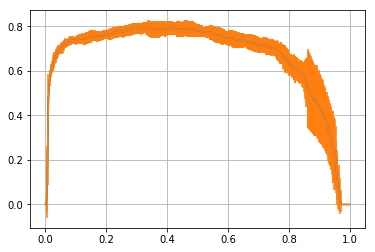

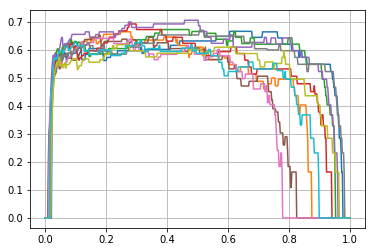

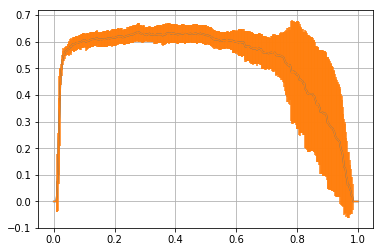

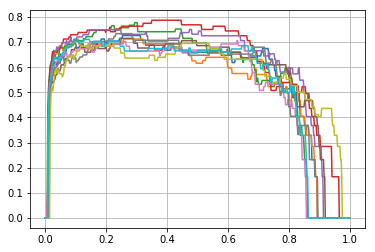

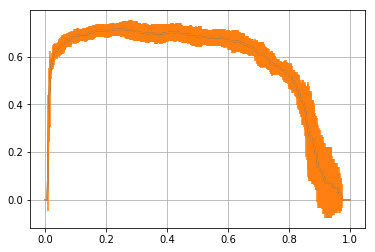

In [27]:
for scores_list in scores_all_fold_list:
    x_line = np.linspace(0.0, 1.0, 501)
    for n_train in range(N_TRAIN):
        plt.plot(x_line, scores_list[n_train])
    plt.grid()
    plt.show()

    mean = np.asarray(scores_list).mean(axis=0)
    std = np.asarray(scores_list).std(axis=0)
    plt.plot(x_line, mean)
    plt.errorbar(x_line, mean, yerr=std)
    plt.grid()
    plt.show()

In [28]:
thr = 0.48
preds_test_sub = np.zeros(len(X_test_input))
for idx, (train_idx, val_idx) in enumerate(splits):
    preds_test_idx = preds_test_all[idx]
    preds_test_sub += preds_test_idx / len(splits)
    
preds_test_sub = (preds_test_sub > thr).astype(int)
preds_test_sub.sum()

199

In [29]:
pred_3 = []
for pred_scaler in preds_test_sub:
    for i in range(3):
        pred_3.append(pred_scaler)
sub = np.squeeze(pred_3)
sub.sum()

597

In [30]:
submission = pd.read_csv('../data/input/sample_submission.csv')
submission['target'] = sub
submission['target'] = submission['target'].astype(int)
submission.to_csv(save_dir + 'submission_v3.csv', index=False)
submission.sum()

signal_id    383962560
target             597
dtype: int64

### predict v4

- 全ての(idx, fold)をrankdataでスケール変換
- 足し合わせて閾値を決める

In [25]:
from sklearn.calibration import _SigmoidCalibration
from scipy.stats import rankdata

np.warnings.filterwarnings('ignore')
splits = list(StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=2019).split(X, fold_index))
scores_all_fold_list = []
preds_val_all = []
preds_test_all = []
y_val = []
val_idx_list = []

for idx, (train_idx, val_idx) in enumerate(splits):
    train_X, train_y, val_X, val_y = X[train_idx], y[train_idx], X[val_idx], y[val_idx]
    scores_list = []
    preds_val_idx = np.zeros(len(val_y))
    preds_test_idx = np.zeros(len(X_test_input))
    
    for n_train in range(N_TRAIN):        
        preds_val = np.load(save_dir + f"preds_val_{n_train}_{idx}.npy")
        preds_test = np.load(save_dir + f"preds_test_{n_train}_{idx}.npy")
        preds_con = np.concatenate((preds_val, preds_test))
        preds_con = rankdata(preds_con) / len(preds_con)
        preds_val_rank = preds_con[0:len(preds_val)]
        preds_test_rank = preds_con[len(preds_val):len(preds_val)+len(preds_test)]
        preds_val_idx += preds_val_rank / N_TRAIN

        score_list = []
        for thr in np.linspace(0.0, 1.0, 501):
            score = matthews_corrcoef(val_y, (preds_val > thr).astype(np.uint8))
            score_list.append(score)
        scores = np.asarray(score_list)
        scores_list.append(scores)
        
    scores_all_fold_list.append(scores_list)
    preds_val_all.append(preds_val_idx)
    preds_test_all.append(preds_test_idx)
    y_val.append(val_y)
    val_idx_list.append(val_idx)
    print(threshold_search(val_y, preds_val_idx))
    
y_val = np.concatenate(y_val)
preds_val_all = np.concatenate(preds_val_all)
val_idx_list = np.concatenate(val_idx_list)
result_df = []
for idx, target, preds in zip(val_idx_list, y_val, preds_val_all):
    result_df.append((idx, target, preds))
result_df = pd.DataFrame(result_df, columns=["idx", "target", "preds"])
result_df = result_df.sort_values("idx").reset_index(drop=True)
extract = result_df.query("idx in @ad_val_idx")

print("val result:", threshold_search(y_val, preds_val_all))
print("adverl result:", threshold_search(extract.target.values, extract.preds.values))

(0.9500000000000001, 0.7419595527914675)
(0.96, 0.7339117527952347)
(0.96, 0.7516547735251194)
(0.97, 0.6997985794736116)
(0.93, 0.6709862765338721)
val result: (0.9500000000000001, 0.7099440449269994)
adverl result: (0.9400000000000001, 0.6002884557845183)
